# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6650369337835667 -2.8045317788430952
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    # batch is supposed to be 1 in this case
    return states, actions, targetQs, reward, cell, g_initial_state, d_initial_state

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [17]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [18]:
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [19]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [20]:
def model_outputs(action_size, hidden_size, states, cell, g_initial_state, d_initial_state):
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    return actions_logits, g_final_state, Qs_logits, d_final_state

In [21]:
def model_loss(action_size, hidden_size, 
               states, actions, targetQs, reward, 
               cell, g_initial_state, d_initial_state):
    # G
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, _ = generator(states=states, num_classes=action_size, 
                                  cell=cell, initial_state=g_initial_state, 
                                  lstm_size=hidden_size, reuse=True)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    print('model loss:', actions_logits.shape, actions_labels.shape)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, _ = discriminator(states=states, actions=actions_logits, 
                                 cell=cell, initial_state=d_initial_state, 
                                 lstm_size=hidden_size, reuse=True)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return g_loss, d_loss, d_lossR, d_lossQ

In [22]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [23]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, batch_size=1, lstm_size=hidden_size)

        # Output of the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_final_state, self.Qs_logits, self.d_final_state = model_outputs(
            action_size=action_size, hidden_size=hidden_size, states=self.states, cell=cell, 
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Create the Model: calculating the loss and forwad pass
        self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell,
            targetQs=self.targetQs, reward=self.reward,  
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [25]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [26]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
model loss: (?, 2) (?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
# batch = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
#     g_initial_state = sess.run(model.g_initial_state)
#     d_initial_state = sess.run(model.d_initial_state)
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)
        prev_g_initial_state = g_initial_state # for training
        prev_d_initial_state = d_initial_state # for training

        # Training steps/batches
        while True:
            action_logits, Q_logits, g_initial_state, d_initial_state = sess.run(fetches=[model.actions_logits,
                                                                                          model.Qs_logits,
                                                                                          model.g_final_state,
                                                                                          model.d_final_state], 
                                                                 feed_dict={model.states: np.reshape(state, [1, -1]),
                                                                            model.g_initial_state: g_initial_state,
                                                                            model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.g_initial_state: prev_g_initial_state,
                                                                       model.d_initial_state: prev_d_initial_state})
 
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-seq.ckpt')

Episode:0 meanR:38.0000 rate:0.0760 gloss:0.0755 dloss:1.4017 dlossR:0.7183 dlossQ:0.6834
Episode:1 meanR:23.0000 rate:0.0160 gloss:0.1360 dloss:1.4721 dlossR:0.7868 dlossQ:0.6853
Episode:2 meanR:18.0000 rate:0.0160 gloss:0.1212 dloss:1.4718 dlossR:0.7863 dlossQ:0.6855
Episode:3 meanR:16.0000 rate:0.0200 gloss:0.1117 dloss:1.4938 dlossR:0.8126 dlossQ:0.6813
Episode:4 meanR:14.8000 rate:0.0200 gloss:0.0782 dloss:1.4802 dlossR:0.7967 dlossQ:0.6835
Episode:5 meanR:14.0000 rate:0.0200 gloss:0.0645 dloss:1.4749 dlossR:0.7901 dlossQ:0.6848
Episode:6 meanR:13.4286 rate:0.0200 gloss:0.0413 dloss:1.4541 dlossR:0.7664 dlossQ:0.6877
Episode:7 meanR:12.7500 rate:0.0160 gloss:0.0268 dloss:1.4224 dlossR:0.7311 dlossQ:0.6913
Episode:8 meanR:12.3333 rate:0.0180 gloss:0.0154 dloss:1.4178 dlossR:0.7263 dlossQ:0.6915
Episode:9 meanR:12.1000 rate:0.0200 gloss:0.0140 dloss:1.4179 dlossR:0.7263 dlossQ:0.6916
Episode:10 meanR:11.8182 rate:0.0180 gloss:-0.0010 dloss:1.3879 dlossR:0.6950 dlossQ:0.6930
Episode:

Episode:90 meanR:13.1758 rate:0.0700 gloss:-0.4789 dloss:1.0689 dlossR:0.4357 dlossQ:0.6332
Episode:91 meanR:13.3043 rate:0.0500 gloss:-0.4819 dloss:1.0560 dlossR:0.4247 dlossQ:0.6314
Episode:92 meanR:13.4946 rate:0.0620 gloss:-0.4923 dloss:1.0553 dlossR:0.4260 dlossQ:0.6292
Episode:93 meanR:13.6702 rate:0.0600 gloss:-0.5189 dloss:1.0400 dlossR:0.4167 dlossQ:0.6233
Episode:94 meanR:13.8211 rate:0.0560 gloss:-0.5052 dloss:1.0442 dlossR:0.4185 dlossQ:0.6257
Episode:95 meanR:13.9688 rate:0.0560 gloss:-0.5087 dloss:1.0431 dlossR:0.4178 dlossQ:0.6252
Episode:96 meanR:14.0103 rate:0.0360 gloss:-0.4959 dloss:1.0406 dlossR:0.4136 dlossQ:0.6270
Episode:97 meanR:14.1122 rate:0.0480 gloss:-0.5133 dloss:1.0349 dlossR:0.4115 dlossQ:0.6234
Episode:98 meanR:14.1919 rate:0.0440 gloss:-0.5050 dloss:1.0353 dlossR:0.4114 dlossQ:0.6240
Episode:99 meanR:14.2900 rate:0.0480 gloss:-0.5182 dloss:1.0271 dlossR:0.4071 dlossQ:0.6199
Episode:100 meanR:14.0800 rate:0.0340 gloss:-0.5285 dloss:1.0193 dlossR:0.4006 d

Episode:180 meanR:27.7900 rate:0.1100 gloss:-1.2990 dloss:0.7421 dlossR:0.3529 dlossQ:0.3892
Episode:181 meanR:28.3300 rate:0.1260 gloss:-1.2992 dloss:0.7736 dlossR:0.3845 dlossQ:0.3892
Episode:182 meanR:28.4600 rate:0.0720 gloss:-1.3312 dloss:0.6599 dlossR:0.2809 dlossQ:0.3790
Episode:183 meanR:28.0600 rate:0.0900 gloss:-1.3274 dloss:0.6953 dlossR:0.3144 dlossQ:0.3809
Episode:184 meanR:27.3800 rate:0.0680 gloss:-1.3342 dloss:0.6531 dlossR:0.2736 dlossQ:0.3795
Episode:185 meanR:27.3200 rate:0.0720 gloss:-1.3469 dloss:0.6553 dlossR:0.2804 dlossQ:0.3750
Episode:186 meanR:27.7200 rate:0.1560 gloss:-1.2888 dloss:0.8391 dlossR:0.4446 dlossQ:0.3945
Episode:187 meanR:27.9000 rate:0.0860 gloss:-1.3564 dloss:0.6779 dlossR:0.3054 dlossQ:0.3725
Episode:188 meanR:27.9900 rate:0.0760 gloss:-1.3755 dloss:0.6544 dlossR:0.2862 dlossQ:0.3681
Episode:189 meanR:28.0200 rate:0.0700 gloss:-1.3673 dloss:0.6461 dlossR:0.2756 dlossQ:0.3705
Episode:190 meanR:27.9300 rate:0.0520 gloss:-1.3574 dloss:0.6188 dloss

Episode:271 meanR:33.2800 rate:0.0520 gloss:-1.4767 dloss:0.5727 dlossR:0.2337 dlossQ:0.3390
Episode:272 meanR:33.7600 rate:0.1500 gloss:-1.6168 dloss:0.7594 dlossR:0.4592 dlossQ:0.3003
Episode:273 meanR:34.0000 rate:0.1180 gloss:-1.6790 dloss:0.6682 dlossR:0.3838 dlossQ:0.2845
Episode:274 meanR:34.0200 rate:0.0920 gloss:-1.6139 dloss:0.6181 dlossR:0.3168 dlossQ:0.3014
Episode:275 meanR:33.7700 rate:0.0480 gloss:-1.5214 dloss:0.5502 dlossR:0.2230 dlossQ:0.3272
Episode:276 meanR:33.4300 rate:0.0400 gloss:-1.4824 dloss:0.5500 dlossR:0.2115 dlossQ:0.3386
Episode:277 meanR:33.1600 rate:0.0380 gloss:-1.4953 dloss:0.5434 dlossR:0.2078 dlossQ:0.3356
Episode:278 meanR:32.7600 rate:0.0300 gloss:-1.4205 dloss:0.5613 dlossR:0.2034 dlossQ:0.3579
Episode:279 meanR:32.5700 rate:0.0420 gloss:-1.4996 dloss:0.5455 dlossR:0.2133 dlossQ:0.3323
Episode:280 meanR:32.1800 rate:0.0320 gloss:-1.4561 dloss:0.5482 dlossR:0.2017 dlossQ:0.3465
Episode:281 meanR:31.7700 rate:0.0440 gloss:-1.5377 dloss:0.5367 dloss

Episode:361 meanR:24.9600 rate:0.1020 gloss:-1.9792 dloss:0.5749 dlossR:0.3612 dlossQ:0.2137
Episode:362 meanR:25.0300 rate:0.0620 gloss:-1.9381 dloss:0.4722 dlossR:0.2461 dlossQ:0.2260
Episode:363 meanR:25.2100 rate:0.0560 gloss:-1.9437 dloss:0.4561 dlossR:0.2301 dlossQ:0.2260
Episode:364 meanR:25.2300 rate:0.0640 gloss:-1.9407 dloss:0.4767 dlossR:0.2516 dlossQ:0.2252
Episode:365 meanR:25.3200 rate:0.0780 gloss:-1.9972 dloss:0.5046 dlossR:0.2918 dlossQ:0.2127
Episode:366 meanR:25.9200 rate:0.1420 gloss:-2.0042 dloss:0.6939 dlossR:0.4850 dlossQ:0.2089
Episode:367 meanR:26.1600 rate:0.0660 gloss:-1.9527 dloss:0.4806 dlossR:0.2572 dlossQ:0.2234
Episode:368 meanR:26.7900 rate:0.1480 gloss:-1.9960 dloss:0.7133 dlossR:0.5024 dlossQ:0.2110
Episode:369 meanR:26.9900 rate:0.0620 gloss:-1.9340 dloss:0.4738 dlossR:0.2461 dlossQ:0.2277
Episode:370 meanR:26.8500 rate:0.0340 gloss:-1.8272 dloss:0.4357 dlossR:0.1802 dlossQ:0.2555
Episode:371 meanR:26.9000 rate:0.0620 gloss:-1.9411 dloss:0.4726 dloss

Episode:452 meanR:34.6800 rate:0.0460 gloss:-1.7143 dloss:0.4845 dlossR:0.2083 dlossQ:0.2761
Episode:453 meanR:34.6200 rate:0.0200 gloss:-1.4674 dloss:0.5290 dlossR:0.1834 dlossQ:0.3456
Episode:454 meanR:34.5800 rate:0.0200 gloss:-1.4828 dloss:0.5215 dlossR:0.1812 dlossQ:0.3403
Episode:455 meanR:34.4600 rate:0.0200 gloss:-1.4710 dloss:0.5282 dlossR:0.1832 dlossQ:0.3450
Episode:456 meanR:34.1800 rate:0.0240 gloss:-1.5479 dloss:0.5007 dlossR:0.1786 dlossQ:0.3221
Episode:457 meanR:34.0700 rate:0.0200 gloss:-1.4956 dloss:0.5194 dlossR:0.1805 dlossQ:0.3388
Episode:458 meanR:33.8700 rate:0.0160 gloss:-1.4001 dloss:0.5575 dlossR:0.1901 dlossQ:0.3673
Episode:459 meanR:33.5600 rate:0.0640 gloss:-1.8100 dloss:0.5002 dlossR:0.2499 dlossQ:0.2504
Episode:460 meanR:33.4900 rate:0.0280 gloss:-1.7012 dloss:0.4623 dlossR:0.1752 dlossQ:0.2871
Episode:461 meanR:33.1100 rate:0.0260 gloss:-1.6504 dloss:0.4755 dlossR:0.1755 dlossQ:0.2999
Episode:462 meanR:32.8900 rate:0.0180 gloss:-1.5044 dloss:0.5168 dloss

Episode:542 meanR:32.9300 rate:0.0860 gloss:-1.8173 dloss:0.5569 dlossR:0.3055 dlossQ:0.2514
Episode:543 meanR:33.0500 rate:0.0540 gloss:-1.7929 dloss:0.4823 dlossR:0.2239 dlossQ:0.2584
Episode:544 meanR:33.0600 rate:0.1120 gloss:-1.8192 dloss:0.6246 dlossR:0.3756 dlossQ:0.2490
Episode:545 meanR:33.1700 rate:0.0820 gloss:-1.7969 dloss:0.5497 dlossR:0.2942 dlossQ:0.2555
Episode:546 meanR:33.7100 rate:0.1500 gloss:-1.7944 dloss:0.7337 dlossR:0.4794 dlossQ:0.2543
Episode:547 meanR:33.9600 rate:0.1200 gloss:-1.8012 dloss:0.6499 dlossR:0.3966 dlossQ:0.2533
Episode:548 meanR:33.8500 rate:0.0660 gloss:-1.7796 dloss:0.5143 dlossR:0.2537 dlossQ:0.2606
Episode:549 meanR:34.0000 rate:0.0620 gloss:-1.7689 dloss:0.5073 dlossR:0.2439 dlossQ:0.2634
Episode:550 meanR:34.1100 rate:0.0740 gloss:-1.7692 dloss:0.5360 dlossR:0.2736 dlossQ:0.2623
Episode:551 meanR:34.1200 rate:0.0540 gloss:-1.7360 dloss:0.4968 dlossR:0.2249 dlossQ:0.2719
Episode:552 meanR:34.5500 rate:0.1320 gloss:-1.7664 dloss:0.6878 dloss

Episode:634 meanR:30.9900 rate:0.0320 gloss:-1.7533 dloss:0.4479 dlossR:0.1762 dlossQ:0.2717
Episode:635 meanR:30.7800 rate:0.0500 gloss:-1.8329 dloss:0.4625 dlossR:0.2124 dlossQ:0.2501
Episode:636 meanR:30.6600 rate:0.0400 gloss:-1.8567 dloss:0.4353 dlossR:0.1888 dlossQ:0.2465
Episode:637 meanR:30.6900 rate:0.1020 gloss:-1.8483 dloss:0.5924 dlossR:0.3493 dlossQ:0.2431
Episode:638 meanR:29.8700 rate:0.0380 gloss:-1.8656 dloss:0.4290 dlossR:0.1842 dlossQ:0.2447
Episode:639 meanR:29.5300 rate:0.0180 gloss:-1.6046 dloss:0.4787 dlossR:0.1661 dlossQ:0.3126
Episode:640 meanR:28.9600 rate:0.0180 gloss:-1.6024 dloss:0.4793 dlossR:0.1663 dlossQ:0.3130
Episode:641 meanR:28.5400 rate:0.0440 gloss:-1.8397 dloss:0.4471 dlossR:0.1983 dlossQ:0.2488
Episode:642 meanR:28.4100 rate:0.0600 gloss:-1.8806 dloss:0.4753 dlossR:0.2373 dlossQ:0.2380
Episode:643 meanR:28.5700 rate:0.0860 gloss:-1.8695 dloss:0.5443 dlossR:0.3066 dlossQ:0.2378
Episode:644 meanR:28.3600 rate:0.0700 gloss:-1.9038 dloss:0.4963 dloss

Episode:723 meanR:23.5400 rate:0.0440 gloss:-2.0279 dloss:0.4035 dlossR:0.1940 dlossQ:0.2094
Episode:724 meanR:23.6000 rate:0.0440 gloss:-2.0074 dloss:0.4069 dlossR:0.1938 dlossQ:0.2131
Episode:725 meanR:23.6800 rate:0.0460 gloss:-2.0249 dloss:0.4078 dlossR:0.1987 dlossQ:0.2091
Episode:726 meanR:23.6800 rate:0.0420 gloss:-2.0140 dloss:0.4011 dlossR:0.1887 dlossQ:0.2124
Episode:727 meanR:23.8300 rate:0.0580 gloss:-2.0833 dloss:0.4298 dlossR:0.2330 dlossQ:0.1968
Episode:728 meanR:23.7500 rate:0.0440 gloss:-2.0754 dloss:0.3949 dlossR:0.1941 dlossQ:0.2008
Episode:729 meanR:23.6100 rate:0.0540 gloss:-2.1125 dloss:0.4141 dlossR:0.2222 dlossQ:0.1920
Episode:730 meanR:23.6700 rate:0.0500 gloss:-2.0957 dloss:0.4066 dlossR:0.2107 dlossQ:0.1959
Episode:731 meanR:23.7700 rate:0.0800 gloss:-2.1542 dloss:0.4852 dlossR:0.3028 dlossQ:0.1824
Episode:732 meanR:23.7000 rate:0.0420 gloss:-2.0525 dloss:0.3945 dlossR:0.1889 dlossQ:0.2056
Episode:733 meanR:24.0400 rate:0.1120 gloss:-2.1282 dloss:0.5878 dloss

Episode:812 meanR:25.5000 rate:0.1200 gloss:-2.1307 dloss:0.6127 dlossR:0.4286 dlossQ:0.1841
Episode:813 meanR:26.0300 rate:0.1340 gloss:-2.0463 dloss:0.6627 dlossR:0.4628 dlossQ:0.1998
Episode:814 meanR:26.2700 rate:0.0860 gloss:-2.1187 dloss:0.5063 dlossR:0.3189 dlossQ:0.1874
Episode:815 meanR:26.5800 rate:0.1120 gloss:-2.0906 dloss:0.5900 dlossR:0.3984 dlossQ:0.1916
Episode:816 meanR:26.6600 rate:0.0580 gloss:-2.0854 dloss:0.4284 dlossR:0.2327 dlossQ:0.1957
Episode:817 meanR:27.0900 rate:0.1380 gloss:-2.0541 dloss:0.6749 dlossR:0.4767 dlossQ:0.1982
Episode:818 meanR:27.3500 rate:0.0920 gloss:-2.0594 dloss:0.5312 dlossR:0.3332 dlossQ:0.1980
Episode:819 meanR:27.4600 rate:0.0680 gloss:-2.0416 dloss:0.4634 dlossR:0.2606 dlossQ:0.2028
Episode:820 meanR:28.5000 rate:0.2440 gloss:-1.9557 dloss:1.0182 dlossR:0.8000 dlossQ:0.2182
Episode:821 meanR:28.5900 rate:0.0640 gloss:-2.0057 dloss:0.4585 dlossR:0.2481 dlossQ:0.2104
Episode:822 meanR:28.7000 rate:0.0560 gloss:-1.9809 dloss:0.4419 dloss

Episode:904 meanR:28.4400 rate:0.0640 gloss:-2.0211 dloss:0.4548 dlossR:0.2477 dlossQ:0.2071
Episode:905 meanR:28.6800 rate:0.0720 gloss:-2.0282 dloss:0.4769 dlossR:0.2715 dlossQ:0.2054
Episode:906 meanR:29.1600 rate:0.1160 gloss:-2.0557 dloss:0.6057 dlossR:0.4073 dlossQ:0.1985
Episode:907 meanR:29.1700 rate:0.0760 gloss:-2.0303 dloss:0.4879 dlossR:0.2831 dlossQ:0.2048
Episode:908 meanR:29.0200 rate:0.0720 gloss:-2.0200 dloss:0.4776 dlossR:0.2708 dlossQ:0.2067
Episode:909 meanR:28.7700 rate:0.0520 gloss:-2.0104 dloss:0.4242 dlossR:0.2138 dlossQ:0.2103
Episode:910 meanR:28.5500 rate:0.0940 gloss:-2.0338 dloss:0.5406 dlossR:0.3374 dlossQ:0.2032
Episode:911 meanR:28.5000 rate:0.0820 gloss:-2.0124 dloss:0.5074 dlossR:0.2998 dlossQ:0.2076
Episode:912 meanR:28.2200 rate:0.0640 gloss:-2.0177 dloss:0.4554 dlossR:0.2476 dlossQ:0.2077
Episode:913 meanR:27.9900 rate:0.0880 gloss:-2.0232 dloss:0.5240 dlossR:0.3185 dlossQ:0.2054
Episode:914 meanR:27.8700 rate:0.0620 gloss:-1.9953 dloss:0.4538 dloss

Episode:994 meanR:35.9700 rate:0.0420 gloss:-1.6975 dloss:0.4767 dlossR:0.1950 dlossQ:0.2817
Episode:995 meanR:36.0400 rate:0.0360 gloss:-1.6931 dloss:0.4668 dlossR:0.1831 dlossQ:0.2837
Episode:996 meanR:36.1700 rate:0.0520 gloss:-1.6674 dloss:0.5066 dlossR:0.2181 dlossQ:0.2885
Episode:997 meanR:36.1500 rate:0.0400 gloss:-1.6714 dloss:0.4803 dlossR:0.1919 dlossQ:0.2884
Episode:998 meanR:36.2300 rate:0.0620 gloss:-1.6576 dloss:0.5315 dlossR:0.2409 dlossQ:0.2906
Episode:999 meanR:36.4600 rate:0.0640 gloss:-1.7161 dloss:0.5208 dlossR:0.2452 dlossQ:0.2757
Episode:1000 meanR:36.3400 rate:0.0420 gloss:-1.7110 dloss:0.4728 dlossR:0.1945 dlossQ:0.2783
Episode:1001 meanR:36.4600 rate:0.0660 gloss:-1.7177 dloss:0.5250 dlossR:0.2499 dlossQ:0.2751
Episode:1002 meanR:36.3400 rate:0.0440 gloss:-1.7185 dloss:0.4751 dlossR:0.1988 dlossQ:0.2763
Episode:1003 meanR:36.3200 rate:0.0380 gloss:-1.7207 dloss:0.4619 dlossR:0.1855 dlossQ:0.2765
Episode:1004 meanR:36.3800 rate:0.0760 gloss:-1.7101 dloss:0.5507 

Episode:1086 meanR:26.2300 rate:0.0320 gloss:-1.8434 dloss:0.4126 dlossR:0.1649 dlossQ:0.2477
Episode:1087 meanR:25.8100 rate:0.0360 gloss:-1.8735 dloss:0.4132 dlossR:0.1729 dlossQ:0.2403
Episode:1088 meanR:25.5200 rate:0.0420 gloss:-1.8844 dloss:0.4237 dlossR:0.1867 dlossQ:0.2370
Episode:1089 meanR:25.5700 rate:0.0640 gloss:-1.9015 dloss:0.4756 dlossR:0.2441 dlossQ:0.2316
Episode:1090 meanR:25.3900 rate:0.0300 gloss:-1.9137 dloss:0.3921 dlossR:0.1588 dlossQ:0.2333
Episode:1091 meanR:25.1900 rate:0.0360 gloss:-1.8892 dloss:0.4084 dlossR:0.1720 dlossQ:0.2364
Episode:1092 meanR:25.1200 rate:0.0200 gloss:-1.8374 dloss:0.3950 dlossR:0.1422 dlossQ:0.2528
Episode:1093 meanR:25.0300 rate:0.0220 gloss:-1.8421 dloss:0.3958 dlossR:0.1450 dlossQ:0.2509
Episode:1094 meanR:25.0300 rate:0.0420 gloss:-1.9203 dloss:0.4156 dlossR:0.1862 dlossQ:0.2294
Episode:1095 meanR:25.3400 rate:0.0980 gloss:-1.9368 dloss:0.5644 dlossR:0.3413 dlossQ:0.2231
Episode:1096 meanR:25.6100 rate:0.1060 gloss:-1.9495 dloss:0

Episode:1174 meanR:23.7800 rate:0.0900 gloss:-2.0059 dloss:0.5299 dlossR:0.3217 dlossQ:0.2082
Episode:1175 meanR:23.9000 rate:0.0580 gloss:-2.0364 dloss:0.4322 dlossR:0.2287 dlossQ:0.2035
Episode:1176 meanR:23.9900 rate:0.0520 gloss:-2.0342 dloss:0.4160 dlossR:0.2116 dlossQ:0.2044
Episode:1177 meanR:24.0100 rate:0.0480 gloss:-2.0190 dloss:0.4083 dlossR:0.2005 dlossQ:0.2078
Episode:1178 meanR:24.0000 rate:0.0240 gloss:-1.9759 dloss:0.3634 dlossR:0.1418 dlossQ:0.2216
Episode:1179 meanR:23.9600 rate:0.0360 gloss:-2.0244 dloss:0.3766 dlossR:0.1682 dlossQ:0.2084
Episode:1180 meanR:24.4100 rate:0.1160 gloss:-1.9692 dloss:0.6123 dlossR:0.3972 dlossQ:0.2151
Episode:1181 meanR:24.4800 rate:0.0380 gloss:-1.9885 dloss:0.3886 dlossR:0.1737 dlossQ:0.2149
Episode:1182 meanR:24.5600 rate:0.0340 gloss:-1.9709 dloss:0.3826 dlossR:0.1640 dlossQ:0.2186
Episode:1183 meanR:24.5900 rate:0.0320 gloss:-1.9448 dloss:0.3843 dlossR:0.1598 dlossQ:0.2245
Episode:1184 meanR:24.5400 rate:0.0200 gloss:-1.9618 dloss:0

Episode:1267 meanR:23.3400 rate:0.0380 gloss:-2.0487 dloss:0.3745 dlossR:0.1719 dlossQ:0.2026
Episode:1268 meanR:23.5000 rate:0.0660 gloss:-2.0338 dloss:0.4544 dlossR:0.2512 dlossQ:0.2032
Episode:1269 meanR:23.5200 rate:0.0340 gloss:-2.0456 dloss:0.3658 dlossR:0.1617 dlossQ:0.2041
Episode:1270 meanR:23.4700 rate:0.0380 gloss:-2.0543 dloss:0.3738 dlossR:0.1720 dlossQ:0.2017
Episode:1271 meanR:23.1800 rate:0.0240 gloss:-2.0479 dloss:0.3437 dlossR:0.1372 dlossQ:0.2064
Episode:1272 meanR:23.1400 rate:0.0360 gloss:-2.0270 dloss:0.3747 dlossR:0.1673 dlossQ:0.2074
Episode:1273 meanR:22.6600 rate:0.0200 gloss:-2.0041 dloss:0.3470 dlossR:0.1305 dlossQ:0.2165
Episode:1274 meanR:22.3700 rate:0.0320 gloss:-2.0494 dloss:0.3600 dlossR:0.1563 dlossQ:0.2037
Episode:1275 meanR:22.2500 rate:0.0340 gloss:-2.0595 dloss:0.3626 dlossR:0.1613 dlossQ:0.2014
Episode:1276 meanR:22.1800 rate:0.0380 gloss:-2.0741 dloss:0.3695 dlossR:0.1717 dlossQ:0.1978
Episode:1277 meanR:22.1900 rate:0.0500 gloss:-2.0740 dloss:0

Episode:1359 meanR:21.8200 rate:0.0340 gloss:-2.0648 dloss:0.3595 dlossR:0.1599 dlossQ:0.1996
Episode:1360 meanR:21.4200 rate:0.0380 gloss:-2.0770 dloss:0.3673 dlossR:0.1705 dlossQ:0.1968
Episode:1361 meanR:21.4800 rate:0.0380 gloss:-2.0839 dloss:0.3659 dlossR:0.1704 dlossQ:0.1955
Episode:1362 meanR:21.4900 rate:0.0300 gloss:-2.0943 dloss:0.3440 dlossR:0.1490 dlossQ:0.1950
Episode:1363 meanR:21.5300 rate:0.0260 gloss:-2.1014 dloss:0.3337 dlossR:0.1388 dlossQ:0.1949
Episode:1364 meanR:21.4800 rate:0.0220 gloss:-2.1187 dloss:0.3231 dlossR:0.1295 dlossQ:0.1937
Episode:1365 meanR:21.4900 rate:0.0200 gloss:-2.1414 dloss:0.3153 dlossR:0.1245 dlossQ:0.1907
Episode:1366 meanR:21.7200 rate:0.0720 gloss:-2.0372 dloss:0.4713 dlossR:0.2688 dlossQ:0.2025
Episode:1367 meanR:21.7300 rate:0.0400 gloss:-2.1299 dloss:0.3624 dlossR:0.1758 dlossQ:0.1866
Episode:1368 meanR:21.5500 rate:0.0300 gloss:-2.0744 dloss:0.3475 dlossR:0.1493 dlossQ:0.1983
Episode:1369 meanR:21.5000 rate:0.0240 gloss:-2.0577 dloss:0

Episode:1447 meanR:19.1400 rate:0.1480 gloss:-2.1085 dloss:0.7030 dlossR:0.5155 dlossQ:0.1875
Episode:1448 meanR:20.8600 rate:0.3940 gloss:-1.9015 dloss:1.5209 dlossR:1.2877 dlossQ:0.2332
Episode:1449 meanR:22.7000 rate:0.3960 gloss:-1.8684 dloss:1.5191 dlossR:1.2779 dlossQ:0.2412
Episode:1450 meanR:24.5200 rate:0.3940 gloss:-1.8060 dloss:1.4959 dlossR:1.2395 dlossQ:0.2564
Episode:1451 meanR:25.8500 rate:0.2880 gloss:-1.7821 dloss:1.1475 dlossR:0.8859 dlossQ:0.2616
Episode:1452 meanR:26.6500 rate:0.1820 gloss:-1.8896 dloss:0.8200 dlossR:0.5861 dlossQ:0.2339
Episode:1453 meanR:27.0100 rate:0.1240 gloss:-1.9202 dloss:0.6427 dlossR:0.4158 dlossQ:0.2269
Episode:1454 meanR:26.6600 rate:0.0500 gloss:-2.0779 dloss:0.3993 dlossR:0.2041 dlossQ:0.1952
Episode:1455 meanR:26.8100 rate:0.0680 gloss:-1.9996 dloss:0.4655 dlossR:0.2555 dlossQ:0.2100
Episode:1456 meanR:26.8200 rate:0.0240 gloss:-2.1313 dloss:0.3217 dlossR:0.1324 dlossQ:0.1893
Episode:1457 meanR:26.8200 rate:0.0200 gloss:-2.1121 dloss:0

Episode:1539 meanR:30.0000 rate:0.0600 gloss:-1.8117 dloss:0.4850 dlossR:0.2318 dlossQ:0.2532
Episode:1540 meanR:30.3400 rate:0.0900 gloss:-1.8018 dloss:0.5635 dlossR:0.3101 dlossQ:0.2535
Episode:1541 meanR:30.4300 rate:0.0440 gloss:-1.8934 dloss:0.4205 dlossR:0.1876 dlossQ:0.2328
Episode:1542 meanR:30.4000 rate:0.0200 gloss:-1.9263 dloss:0.3579 dlossR:0.1290 dlossQ:0.2288
Episode:1543 meanR:30.3500 rate:0.0200 gloss:-1.8996 dloss:0.3650 dlossR:0.1304 dlossQ:0.2346
Episode:1544 meanR:30.3300 rate:0.0220 gloss:-1.9309 dloss:0.3607 dlossR:0.1329 dlossQ:0.2278
Episode:1545 meanR:30.3100 rate:0.0220 gloss:-1.9330 dloss:0.3599 dlossR:0.1327 dlossQ:0.2272
Episode:1546 meanR:30.5400 rate:0.0660 gloss:-1.9788 dloss:0.4625 dlossR:0.2486 dlossQ:0.2138
Episode:1547 meanR:29.9200 rate:0.0240 gloss:-1.9194 dloss:0.3678 dlossR:0.1377 dlossQ:0.2301
Episode:1548 meanR:28.0500 rate:0.0200 gloss:-1.9790 dloss:0.3444 dlossR:0.1264 dlossQ:0.2180
Episode:1549 meanR:26.3000 rate:0.0460 gloss:-1.9265 dloss:0

Episode:1629 meanR:27.3500 rate:0.0360 gloss:-1.9360 dloss:0.3919 dlossR:0.1664 dlossQ:0.2255
Episode:1630 meanR:27.1900 rate:0.0340 gloss:-1.9532 dloss:0.3824 dlossR:0.1606 dlossQ:0.2218
Episode:1631 meanR:27.0400 rate:0.0420 gloss:-1.8953 dloss:0.4171 dlossR:0.1831 dlossQ:0.2340
Episode:1632 meanR:26.9100 rate:0.0480 gloss:-1.8505 dloss:0.4468 dlossR:0.2010 dlossQ:0.2458
Episode:1633 meanR:26.7800 rate:0.0460 gloss:-1.9376 dloss:0.4163 dlossR:0.1926 dlossQ:0.2237
Episode:1634 meanR:26.5600 rate:0.0240 gloss:-1.9966 dloss:0.3473 dlossR:0.1340 dlossQ:0.2132
Episode:1635 meanR:26.5400 rate:0.0180 gloss:-1.9657 dloss:0.3436 dlossR:0.1226 dlossQ:0.2210
Episode:1636 meanR:26.5400 rate:0.0200 gloss:-2.1045 dloss:0.3155 dlossR:0.1217 dlossQ:0.1937
Episode:1637 meanR:26.5200 rate:0.0180 gloss:-2.0853 dloss:0.3178 dlossR:0.1186 dlossQ:0.1992
Episode:1638 meanR:26.8600 rate:0.0880 gloss:-1.8925 dloss:0.5417 dlossR:0.3087 dlossQ:0.2330
Episode:1639 meanR:27.5300 rate:0.1940 gloss:-1.8532 dloss:0

Episode:1717 meanR:32.0200 rate:0.0520 gloss:-1.9326 dloss:0.4327 dlossR:0.2083 dlossQ:0.2244
Episode:1718 meanR:32.0300 rate:0.1320 gloss:-1.6421 dloss:0.7073 dlossR:0.4120 dlossQ:0.2953
Episode:1719 meanR:32.4800 rate:0.1360 gloss:-1.6585 dloss:0.7145 dlossR:0.4235 dlossQ:0.2910
Episode:1720 meanR:32.6700 rate:0.0820 gloss:-1.8259 dloss:0.5395 dlossR:0.2900 dlossQ:0.2495
Episode:1721 meanR:32.9600 rate:0.1180 gloss:-1.6946 dloss:0.6607 dlossR:0.3793 dlossQ:0.2814
Episode:1722 meanR:33.2000 rate:0.0820 gloss:-1.7705 dloss:0.5522 dlossR:0.2889 dlossQ:0.2633
Episode:1723 meanR:33.3300 rate:0.0780 gloss:-1.7197 dloss:0.5539 dlossR:0.2777 dlossQ:0.2761
Episode:1724 meanR:33.4700 rate:0.0740 gloss:-1.8518 dloss:0.5118 dlossR:0.2686 dlossQ:0.2432
Episode:1725 meanR:33.4800 rate:0.0880 gloss:-1.7644 dloss:0.5681 dlossR:0.3041 dlossQ:0.2640
Episode:1726 meanR:33.4700 rate:0.0600 gloss:-1.7852 dloss:0.4897 dlossR:0.2309 dlossQ:0.2588
Episode:1727 meanR:33.4500 rate:0.0380 gloss:-1.8704 dloss:0

Episode:1805 meanR:25.6700 rate:0.0280 gloss:-2.1157 dloss:0.3287 dlossR:0.1392 dlossQ:0.1895
Episode:1806 meanR:25.6700 rate:0.0320 gloss:-2.0681 dloss:0.3495 dlossR:0.1513 dlossQ:0.1982
Episode:1807 meanR:25.6500 rate:0.0460 gloss:-2.0347 dloss:0.3953 dlossR:0.1912 dlossQ:0.2042
Episode:1808 meanR:25.8300 rate:0.0720 gloss:-1.9045 dloss:0.4968 dlossR:0.2646 dlossQ:0.2323
Episode:1809 meanR:25.6900 rate:0.0280 gloss:-2.1083 dloss:0.3306 dlossR:0.1397 dlossQ:0.1909
Episode:1810 meanR:25.4800 rate:0.0240 gloss:-2.1682 dloss:0.3081 dlossR:0.1275 dlossQ:0.1806
Episode:1811 meanR:25.4000 rate:0.0200 gloss:-2.2213 dloss:0.2882 dlossR:0.1158 dlossQ:0.1724
Episode:1812 meanR:25.2700 rate:0.0240 gloss:-2.2122 dloss:0.2991 dlossR:0.1263 dlossQ:0.1728
Episode:1813 meanR:25.2700 rate:0.0380 gloss:-2.0996 dloss:0.3599 dlossR:0.1678 dlossQ:0.1921
Episode:1814 meanR:25.8400 rate:0.1480 gloss:-1.4160 dloss:0.8234 dlossR:0.4534 dlossQ:0.3700
Episode:1815 meanR:26.1000 rate:0.1400 gloss:-1.3719 dloss:0

Episode:1894 meanR:24.2900 rate:0.0440 gloss:-2.0488 dloss:0.3862 dlossR:0.1850 dlossQ:0.2012
Episode:1895 meanR:24.0400 rate:0.0520 gloss:-1.9438 dloss:0.4350 dlossR:0.2095 dlossQ:0.2255
Episode:1896 meanR:23.7000 rate:0.0360 gloss:-2.1175 dloss:0.3493 dlossR:0.1612 dlossQ:0.1881
Episode:1897 meanR:23.8500 rate:0.0560 gloss:-1.9876 dloss:0.4330 dlossR:0.2196 dlossQ:0.2134
Episode:1898 meanR:24.0400 rate:0.0560 gloss:-2.0202 dloss:0.4264 dlossR:0.2198 dlossQ:0.2066
Episode:1899 meanR:24.2300 rate:0.0660 gloss:-1.8901 dloss:0.4850 dlossR:0.2481 dlossQ:0.2368
Episode:1900 meanR:24.3500 rate:0.0520 gloss:-1.9992 dloss:0.4197 dlossR:0.2082 dlossQ:0.2114
Episode:1901 meanR:24.5500 rate:0.0640 gloss:-1.9969 dloss:0.4536 dlossR:0.2427 dlossQ:0.2109
Episode:1902 meanR:24.8200 rate:0.0820 gloss:-1.7993 dloss:0.5483 dlossR:0.2904 dlossQ:0.2580
Episode:1903 meanR:25.1200 rate:0.0840 gloss:-1.8160 dloss:0.5489 dlossR:0.2957 dlossQ:0.2532
Episode:1904 meanR:25.2800 rate:0.0600 gloss:-1.8692 dloss:0

Episode:1982 meanR:37.3400 rate:0.0360 gloss:-1.7000 dloss:0.4615 dlossR:0.1771 dlossQ:0.2844
Episode:1983 meanR:37.4300 rate:0.0440 gloss:-1.6227 dloss:0.5057 dlossR:0.2007 dlossQ:0.3051
Episode:1984 meanR:37.4800 rate:0.0440 gloss:-1.6496 dloss:0.4975 dlossR:0.1993 dlossQ:0.2982
Episode:1985 meanR:37.5700 rate:0.1080 gloss:-1.5757 dloss:0.6627 dlossR:0.3488 dlossQ:0.3139
Episode:1986 meanR:37.5300 rate:0.0740 gloss:-1.6525 dloss:0.5613 dlossR:0.2677 dlossQ:0.2936
Episode:1987 meanR:37.5400 rate:0.1080 gloss:-1.5515 dloss:0.6696 dlossR:0.3484 dlossQ:0.3212
Episode:1988 meanR:37.5700 rate:0.0380 gloss:-1.8213 dloss:0.4271 dlossR:0.1746 dlossQ:0.2525
Episode:1989 meanR:37.6300 rate:0.0480 gloss:-1.7321 dloss:0.4772 dlossR:0.2029 dlossQ:0.2743
Episode:1990 meanR:37.7100 rate:0.0580 gloss:-1.6729 dloss:0.5196 dlossR:0.2296 dlossQ:0.2900
Episode:1991 meanR:37.7000 rate:0.0320 gloss:-1.8903 dloss:0.3931 dlossR:0.1566 dlossQ:0.2365
Episode:1992 meanR:37.7100 rate:0.0260 gloss:-1.9494 dloss:0

Episode:2071 meanR:32.4400 rate:0.0480 gloss:-1.7360 dloss:0.4810 dlossR:0.2047 dlossQ:0.2763
Episode:2072 meanR:32.5800 rate:0.0540 gloss:-1.7839 dloss:0.4792 dlossR:0.2168 dlossQ:0.2624
Episode:2073 meanR:32.5600 rate:0.0260 gloss:-1.9727 dloss:0.3574 dlossR:0.1380 dlossQ:0.2195
Episode:2074 meanR:32.5100 rate:0.0280 gloss:-1.9659 dloss:0.3648 dlossR:0.1435 dlossQ:0.2213
Episode:2075 meanR:32.5000 rate:0.0320 gloss:-1.9223 dloss:0.3871 dlossR:0.1559 dlossQ:0.2312
Episode:2076 meanR:32.7300 rate:0.0840 gloss:-1.6433 dloss:0.5912 dlossR:0.2933 dlossQ:0.2979
Episode:2077 meanR:32.7800 rate:0.0740 gloss:-1.6920 dloss:0.5539 dlossR:0.2686 dlossQ:0.2853
Episode:2078 meanR:32.8400 rate:0.0580 gloss:-1.7162 dloss:0.5114 dlossR:0.2300 dlossQ:0.2813
Episode:2079 meanR:32.9200 rate:0.0360 gloss:-1.9031 dloss:0.4032 dlossR:0.1673 dlossQ:0.2359
Episode:2080 meanR:32.9000 rate:0.0220 gloss:-2.0610 dloss:0.3249 dlossR:0.1241 dlossQ:0.2008
Episode:2081 meanR:32.8900 rate:0.0280 gloss:-1.9849 dloss:0

Episode:2160 meanR:35.8600 rate:0.0400 gloss:-1.8313 dloss:0.4323 dlossR:0.1801 dlossQ:0.2522
Episode:2161 meanR:35.9000 rate:0.0560 gloss:-1.6535 dloss:0.5230 dlossR:0.2263 dlossQ:0.2967
Episode:2162 meanR:35.9000 rate:0.0460 gloss:-1.7505 dloss:0.4711 dlossR:0.1987 dlossQ:0.2725
Episode:2163 meanR:36.0100 rate:0.0520 gloss:-1.6897 dloss:0.5040 dlossR:0.2160 dlossQ:0.2880
Episode:2164 meanR:35.8600 rate:0.0460 gloss:-1.8288 dloss:0.4466 dlossR:0.1949 dlossQ:0.2516
Episode:2165 meanR:36.0200 rate:0.0820 gloss:-1.5348 dloss:0.6191 dlossR:0.2904 dlossQ:0.3287
Episode:2166 meanR:35.9700 rate:0.0420 gloss:-1.7615 dloss:0.4555 dlossR:0.1873 dlossQ:0.2683
Episode:2167 meanR:35.6700 rate:0.0300 gloss:-1.9293 dloss:0.3772 dlossR:0.1493 dlossQ:0.2280
Episode:2168 meanR:35.7700 rate:0.0580 gloss:-1.6650 dloss:0.5258 dlossR:0.2315 dlossQ:0.2943
Episode:2169 meanR:35.7100 rate:0.0420 gloss:-1.8919 dloss:0.4232 dlossR:0.1840 dlossQ:0.2392
Episode:2170 meanR:35.7800 rate:0.0480 gloss:-1.8269 dloss:0

Episode:2248 meanR:29.3800 rate:0.1540 gloss:-1.4836 dloss:0.7958 dlossR:0.4540 dlossQ:0.3418
Episode:2249 meanR:29.4400 rate:0.0680 gloss:-1.5803 dloss:0.5764 dlossR:0.2585 dlossQ:0.3179
Episode:2250 meanR:29.4300 rate:0.0660 gloss:-1.6946 dloss:0.5329 dlossR:0.2484 dlossQ:0.2845
Episode:2251 meanR:29.6600 rate:0.1100 gloss:-1.5097 dloss:0.6895 dlossR:0.3539 dlossQ:0.3356
Episode:2252 meanR:29.6800 rate:0.0840 gloss:-1.5052 dloss:0.6353 dlossR:0.2967 dlossQ:0.3386
Episode:2253 meanR:29.7100 rate:0.0560 gloss:-1.6344 dloss:0.5342 dlossR:0.2295 dlossQ:0.3046
Episode:2254 meanR:29.7900 rate:0.0500 gloss:-1.8215 dloss:0.4580 dlossR:0.2051 dlossQ:0.2529
Episode:2255 meanR:29.8800 rate:0.0640 gloss:-1.6271 dloss:0.5537 dlossR:0.2480 dlossQ:0.3057
Episode:2256 meanR:30.0500 rate:0.1000 gloss:-1.5799 dloss:0.6456 dlossR:0.3309 dlossQ:0.3147
Episode:2257 meanR:30.2800 rate:0.0880 gloss:-1.4848 dloss:0.6511 dlossR:0.3064 dlossQ:0.3447
Episode:2258 meanR:30.4700 rate:0.0980 gloss:-1.4784 dloss:0

Episode:2339 meanR:26.1000 rate:0.0740 gloss:-1.7491 dloss:0.5409 dlossR:0.2690 dlossQ:0.2718
Episode:2340 meanR:26.2900 rate:0.1100 gloss:-1.5169 dloss:0.6947 dlossR:0.3576 dlossQ:0.3371
Episode:2341 meanR:27.0200 rate:0.1820 gloss:-1.6715 dloss:0.8385 dlossR:0.5489 dlossQ:0.2896
Episode:2342 meanR:27.8500 rate:0.2220 gloss:-1.6946 dloss:0.9490 dlossR:0.6650 dlossQ:0.2840
Episode:2343 meanR:28.5600 rate:0.1780 gloss:-1.3486 dloss:0.8908 dlossR:0.5041 dlossQ:0.3867
Episode:2344 meanR:29.1000 rate:0.1460 gloss:-1.3323 dloss:0.8302 dlossR:0.4371 dlossQ:0.3931
Episode:2345 meanR:29.3900 rate:0.1500 gloss:-1.3508 dloss:0.8340 dlossR:0.4467 dlossQ:0.3874
Episode:2346 meanR:29.7200 rate:0.1140 gloss:-1.3634 dloss:0.7579 dlossR:0.3728 dlossQ:0.3851
Episode:2347 meanR:30.1500 rate:0.1220 gloss:-1.4188 dloss:0.7563 dlossR:0.3885 dlossQ:0.3679
Episode:2348 meanR:29.7000 rate:0.0640 gloss:-1.7200 dloss:0.5304 dlossR:0.2474 dlossQ:0.2831
Episode:2349 meanR:29.5900 rate:0.0460 gloss:-1.9103 dloss:0

Episode:2427 meanR:34.0600 rate:0.0680 gloss:-1.5472 dloss:0.5831 dlossR:0.2578 dlossQ:0.3254
Episode:2428 meanR:34.2300 rate:0.0800 gloss:-1.4777 dloss:0.6324 dlossR:0.2871 dlossQ:0.3453
Episode:2429 meanR:34.2500 rate:0.0660 gloss:-1.5902 dloss:0.5664 dlossR:0.2524 dlossQ:0.3140
Episode:2430 meanR:34.3400 rate:0.0580 gloss:-1.6183 dloss:0.5409 dlossR:0.2336 dlossQ:0.3072
Episode:2431 meanR:34.2500 rate:0.0240 gloss:-1.9872 dloss:0.3459 dlossR:0.1310 dlossQ:0.2149
Episode:2432 meanR:34.0900 rate:0.0200 gloss:-2.0163 dloss:0.3292 dlossR:0.1202 dlossQ:0.2090
Episode:2433 meanR:34.3200 rate:0.1100 gloss:-1.5286 dloss:0.6825 dlossR:0.3537 dlossQ:0.3288
Episode:2434 meanR:34.7000 rate:0.1160 gloss:-1.4857 dloss:0.7079 dlossR:0.3667 dlossQ:0.3412
Episode:2435 meanR:35.3000 rate:0.1700 gloss:-1.2490 dloss:0.8865 dlossR:0.4728 dlossQ:0.4137
Episode:2436 meanR:35.4600 rate:0.0540 gloss:-1.4679 dloss:0.5868 dlossR:0.2357 dlossQ:0.3511
Episode:2437 meanR:35.5700 rate:0.0400 gloss:-1.6198 dloss:0

Episode:2515 meanR:32.2400 rate:0.1320 gloss:-1.7077 dloss:0.6983 dlossR:0.4185 dlossQ:0.2798
Episode:2516 meanR:31.6200 rate:0.1460 gloss:-1.6578 dloss:0.7442 dlossR:0.4509 dlossQ:0.2933
Episode:2517 meanR:31.2200 rate:0.1140 gloss:-1.7205 dloss:0.6489 dlossR:0.3718 dlossQ:0.2771
Episode:2518 meanR:30.0000 rate:0.0260 gloss:-2.2578 dloss:0.2910 dlossR:0.1281 dlossQ:0.1629
Episode:2519 meanR:28.9800 rate:0.0420 gloss:-2.0761 dloss:0.3746 dlossR:0.1784 dlossQ:0.1963
Episode:2520 meanR:28.2500 rate:0.0180 gloss:-2.3247 dloss:0.2590 dlossR:0.1047 dlossQ:0.1542
Episode:2521 meanR:27.2600 rate:0.0180 gloss:-2.3295 dloss:0.2579 dlossR:0.1046 dlossQ:0.1533
Episode:2522 meanR:27.0900 rate:0.0720 gloss:-1.7549 dloss:0.5381 dlossR:0.2656 dlossQ:0.2725
Episode:2523 meanR:27.5700 rate:0.1640 gloss:-1.5249 dloss:0.8138 dlossR:0.4829 dlossQ:0.3308
Episode:2524 meanR:28.2900 rate:0.1740 gloss:-1.4056 dloss:0.8619 dlossR:0.4950 dlossQ:0.3669
Episode:2525 meanR:29.4000 rate:0.2880 gloss:-1.3302 dloss:1

Episode:2605 meanR:34.1700 rate:0.0760 gloss:-1.7663 dloss:0.5405 dlossR:0.2737 dlossQ:0.2668
Episode:2606 meanR:34.3000 rate:0.0420 gloss:-1.8736 dloss:0.4291 dlossR:0.1845 dlossQ:0.2446
Episode:2607 meanR:33.9700 rate:0.0260 gloss:-2.1368 dloss:0.3182 dlossR:0.1313 dlossQ:0.1869
Episode:2608 meanR:33.5300 rate:0.0260 gloss:-2.1553 dloss:0.3134 dlossR:0.1306 dlossQ:0.1828
Episode:2609 meanR:33.1300 rate:0.0260 gloss:-2.1529 dloss:0.3140 dlossR:0.1307 dlossQ:0.1833
Episode:2610 meanR:32.8500 rate:0.0200 gloss:-2.2928 dloss:0.2691 dlossR:0.1102 dlossQ:0.1588
Episode:2611 meanR:32.9200 rate:0.0360 gloss:-1.9994 dloss:0.3782 dlossR:0.1634 dlossQ:0.2148
Episode:2612 meanR:33.1000 rate:0.0540 gloss:-1.8807 dloss:0.4548 dlossR:0.2149 dlossQ:0.2399
Episode:2613 meanR:33.2200 rate:0.0420 gloss:-1.9958 dloss:0.3937 dlossR:0.1796 dlossQ:0.2141
Episode:2614 meanR:33.3000 rate:0.0380 gloss:-2.0056 dloss:0.3806 dlossR:0.1683 dlossQ:0.2124
Episode:2615 meanR:32.9200 rate:0.0560 gloss:-1.9045 dloss:0

Episode:2695 meanR:25.7400 rate:0.0720 gloss:-1.7788 dloss:0.5296 dlossR:0.2643 dlossQ:0.2654
Episode:2696 meanR:26.7600 rate:0.2320 gloss:-1.2713 dloss:1.0210 dlossR:0.6107 dlossQ:0.4103
Episode:2697 meanR:26.7000 rate:0.0440 gloss:-1.9819 dloss:0.4038 dlossR:0.1859 dlossQ:0.2179
Episode:2698 meanR:26.5700 rate:0.0480 gloss:-1.9096 dloss:0.4331 dlossR:0.1985 dlossQ:0.2345
Episode:2699 meanR:26.3100 rate:0.0240 gloss:-2.3066 dloss:0.2763 dlossR:0.1212 dlossQ:0.1551
Episode:2700 meanR:26.6300 rate:0.0920 gloss:-1.6729 dloss:0.6058 dlossR:0.3143 dlossQ:0.2916
Episode:2701 meanR:26.7900 rate:0.0600 gloss:-1.8108 dloss:0.4901 dlossR:0.2325 dlossQ:0.2576
Episode:2702 meanR:26.8800 rate:0.0460 gloss:-1.9062 dloss:0.4311 dlossR:0.1942 dlossQ:0.2369
Episode:2703 meanR:26.9100 rate:0.0400 gloss:-1.9293 dloss:0.4094 dlossR:0.1775 dlossQ:0.2319
Episode:2704 meanR:26.9000 rate:0.0380 gloss:-2.0067 dloss:0.3843 dlossR:0.1696 dlossQ:0.2147
Episode:2705 meanR:26.6200 rate:0.0200 gloss:-2.3230 dloss:0

Episode:2785 meanR:21.8800 rate:0.0200 gloss:-2.4647 dloss:0.2399 dlossR:0.1070 dlossQ:0.1329
Episode:2786 meanR:22.0600 rate:0.0600 gloss:-2.0142 dloss:0.4469 dlossR:0.2337 dlossQ:0.2132
Episode:2787 meanR:22.3100 rate:0.0800 gloss:-1.8267 dloss:0.5427 dlossR:0.2874 dlossQ:0.2553
Episode:2788 meanR:22.9300 rate:0.1760 gloss:-1.4920 dloss:0.8542 dlossR:0.5110 dlossQ:0.3432
Episode:2789 meanR:23.1100 rate:0.0740 gloss:-1.9772 dloss:0.4914 dlossR:0.2729 dlossQ:0.2186
Episode:2790 meanR:23.3500 rate:0.0680 gloss:-1.9321 dloss:0.4827 dlossR:0.2543 dlossQ:0.2284
Episode:2791 meanR:22.9700 rate:0.0560 gloss:-1.9792 dloss:0.4387 dlossR:0.2203 dlossQ:0.2184
Episode:2792 meanR:22.8700 rate:0.0240 gloss:-2.3652 dloss:0.2664 dlossR:0.1201 dlossQ:0.1463
Episode:2793 meanR:22.7300 rate:0.0260 gloss:-2.3511 dloss:0.2743 dlossR:0.1263 dlossQ:0.1480
Episode:2794 meanR:22.6300 rate:0.0520 gloss:-2.0160 dloss:0.4183 dlossR:0.2084 dlossQ:0.2099
Episode:2795 meanR:22.5700 rate:0.0600 gloss:-1.9380 dloss:0

Episode:2874 meanR:23.5600 rate:0.0400 gloss:-2.0850 dloss:0.3697 dlossR:0.1728 dlossQ:0.1970
Episode:2875 meanR:23.6800 rate:0.0580 gloss:-1.8844 dloss:0.4685 dlossR:0.2270 dlossQ:0.2415
Episode:2876 meanR:23.6200 rate:0.0460 gloss:-2.0147 dloss:0.4040 dlossR:0.1917 dlossQ:0.2123
Episode:2877 meanR:23.7300 rate:0.0540 gloss:-1.9532 dloss:0.4397 dlossR:0.2148 dlossQ:0.2249
Episode:2878 meanR:23.8100 rate:0.0480 gloss:-1.9861 dloss:0.4154 dlossR:0.1975 dlossQ:0.2179
Episode:2879 meanR:23.7600 rate:0.0320 gloss:-2.1784 dloss:0.3260 dlossR:0.1473 dlossQ:0.1787
Episode:2880 meanR:23.9500 rate:0.0700 gloss:-1.8585 dloss:0.5057 dlossR:0.2594 dlossQ:0.2463
Episode:2881 meanR:24.0400 rate:0.0420 gloss:-2.0594 dloss:0.3816 dlossR:0.1791 dlossQ:0.2025
Episode:2882 meanR:24.1100 rate:0.0320 gloss:-2.1925 dloss:0.3233 dlossR:0.1471 dlossQ:0.1762
Episode:2883 meanR:24.1100 rate:0.0540 gloss:-1.9335 dloss:0.4453 dlossR:0.2153 dlossQ:0.2300
Episode:2884 meanR:24.2500 rate:0.0480 gloss:-1.9934 dloss:0

Episode:2966 meanR:24.5800 rate:0.0220 gloss:-2.3407 dloss:0.2643 dlossR:0.1140 dlossQ:0.1504
Episode:2967 meanR:24.2700 rate:0.0200 gloss:-2.4280 dloss:0.2431 dlossR:0.1064 dlossQ:0.1366
Episode:2968 meanR:24.0300 rate:0.0180 gloss:-2.4032 dloss:0.2423 dlossR:0.1012 dlossQ:0.1411
Episode:2969 meanR:23.7600 rate:0.0240 gloss:-2.4072 dloss:0.2583 dlossR:0.1192 dlossQ:0.1391
Episode:2970 meanR:23.6500 rate:0.0280 gloss:-2.3185 dloss:0.2864 dlossR:0.1329 dlossQ:0.1535
Episode:2971 meanR:23.5200 rate:0.0240 gloss:-2.3699 dloss:0.2665 dlossR:0.1199 dlossQ:0.1465
Episode:2972 meanR:23.3900 rate:0.0300 gloss:-2.2218 dloss:0.3130 dlossR:0.1409 dlossQ:0.1721
Episode:2973 meanR:23.4100 rate:0.0520 gloss:-1.9427 dloss:0.4376 dlossR:0.2096 dlossQ:0.2280
Episode:2974 meanR:23.4400 rate:0.0460 gloss:-1.9808 dloss:0.4138 dlossR:0.1928 dlossQ:0.2210
Episode:2975 meanR:23.5400 rate:0.0780 gloss:-1.7700 dloss:0.5468 dlossR:0.2797 dlossQ:0.2671
Episode:2976 meanR:23.6500 rate:0.0680 gloss:-1.8156 dloss:0

Episode:3056 meanR:25.7200 rate:0.0280 gloss:-2.1980 dloss:0.3102 dlossR:0.1347 dlossQ:0.1755
Episode:3057 meanR:25.7300 rate:0.0380 gloss:-2.0961 dloss:0.3634 dlossR:0.1671 dlossQ:0.1963
Episode:3058 meanR:25.6200 rate:0.0360 gloss:-2.0907 dloss:0.3586 dlossR:0.1613 dlossQ:0.1973
Episode:3059 meanR:25.5900 rate:0.0540 gloss:-1.9231 dloss:0.4505 dlossR:0.2163 dlossQ:0.2342
Episode:3060 meanR:25.8100 rate:0.0700 gloss:-1.8355 dloss:0.5165 dlossR:0.2613 dlossQ:0.2552
Episode:3061 meanR:26.3200 rate:0.1340 gloss:-1.5469 dloss:0.7463 dlossR:0.4163 dlossQ:0.3300
Episode:3062 meanR:26.7100 rate:0.1120 gloss:-1.6762 dloss:0.6628 dlossR:0.3682 dlossQ:0.2945
Episode:3063 meanR:26.7000 rate:0.0260 gloss:-2.4380 dloss:0.2620 dlossR:0.1258 dlossQ:0.1363
Episode:3064 meanR:26.6200 rate:0.0160 gloss:-2.6231 dloss:0.2053 dlossR:0.0920 dlossQ:0.1132
Episode:3065 meanR:26.4300 rate:0.0180 gloss:-2.5820 dloss:0.2159 dlossR:0.0986 dlossQ:0.1172
Episode:3066 meanR:26.4900 rate:0.0340 gloss:-2.2242 dloss:0

Episode:3147 meanR:25.1500 rate:0.0300 gloss:-2.1141 dloss:0.3342 dlossR:0.1426 dlossQ:0.1916
Episode:3148 meanR:25.1000 rate:0.0340 gloss:-2.0385 dloss:0.3631 dlossR:0.1562 dlossQ:0.2070
Episode:3149 meanR:25.1700 rate:0.0400 gloss:-1.9783 dloss:0.3958 dlossR:0.1752 dlossQ:0.2207
Episode:3150 meanR:25.1700 rate:0.0280 gloss:-2.1591 dloss:0.3190 dlossR:0.1358 dlossQ:0.1832
Episode:3151 meanR:25.1600 rate:0.0280 gloss:-2.1475 dloss:0.3228 dlossR:0.1365 dlossQ:0.1863
Episode:3152 meanR:25.2700 rate:0.0520 gloss:-1.8613 dloss:0.4583 dlossR:0.2110 dlossQ:0.2473
Episode:3153 meanR:25.3300 rate:0.0400 gloss:-1.9865 dloss:0.3931 dlossR:0.1747 dlossQ:0.2184
Episode:3154 meanR:25.3800 rate:0.0380 gloss:-2.0557 dloss:0.3724 dlossR:0.1679 dlossQ:0.2045
Episode:3155 meanR:25.6300 rate:0.0860 gloss:-1.8185 dloss:0.5571 dlossR:0.3023 dlossQ:0.2548
Episode:3156 meanR:25.7500 rate:0.0520 gloss:-1.9740 dloss:0.4288 dlossR:0.2088 dlossQ:0.2200
Episode:3157 meanR:25.6600 rate:0.0200 gloss:-2.4556 dloss:0

Episode:3235 meanR:39.1400 rate:0.1080 gloss:-0.8693 dloss:0.9225 dlossR:0.3921 dlossQ:0.5304
Episode:3236 meanR:39.4200 rate:0.0840 gloss:-0.9667 dloss:0.8482 dlossR:0.3470 dlossQ:0.5012
Episode:3237 meanR:39.6300 rate:0.0760 gloss:-1.0266 dloss:0.8093 dlossR:0.3264 dlossQ:0.4829
Episode:3238 meanR:39.5600 rate:0.0480 gloss:-1.1646 dloss:0.7071 dlossR:0.2645 dlossQ:0.4426
Episode:3239 meanR:39.5200 rate:0.0340 gloss:-1.3761 dloss:0.5868 dlossR:0.2077 dlossQ:0.3790
Episode:3240 meanR:39.4600 rate:0.0280 gloss:-1.5328 dloss:0.5058 dlossR:0.1740 dlossQ:0.3318
Episode:3241 meanR:39.4400 rate:0.0320 gloss:-1.4679 dloss:0.5404 dlossR:0.1896 dlossQ:0.3508
Episode:3242 meanR:39.4100 rate:0.0240 gloss:-1.6839 dloss:0.4364 dlossR:0.1486 dlossQ:0.2879
Episode:3243 meanR:39.2900 rate:0.0260 gloss:-1.6374 dloss:0.4577 dlossR:0.1570 dlossQ:0.3007
Episode:3244 meanR:39.1400 rate:0.0280 gloss:-1.5861 dloss:0.4832 dlossR:0.1672 dlossQ:0.3160
Episode:3245 meanR:39.1300 rate:0.0400 gloss:-1.3495 dloss:0

Episode:3325 meanR:33.0700 rate:0.0980 gloss:-1.4669 dloss:0.6775 dlossR:0.3278 dlossQ:0.3497
Episode:3326 meanR:32.7800 rate:0.1700 gloss:-1.3458 dloss:0.8646 dlossR:0.4799 dlossQ:0.3847
Episode:3327 meanR:32.2600 rate:0.1040 gloss:-1.4254 dloss:0.7062 dlossR:0.3428 dlossQ:0.3634
Episode:3328 meanR:32.1000 rate:0.1280 gloss:-1.4421 dloss:0.7491 dlossR:0.3932 dlossQ:0.3559
Episode:3329 meanR:31.6100 rate:0.0700 gloss:-1.5671 dloss:0.5883 dlossR:0.2646 dlossQ:0.3237
Episode:3330 meanR:31.0300 rate:0.0720 gloss:-1.5612 dloss:0.5948 dlossR:0.2694 dlossQ:0.3254
Episode:3331 meanR:31.0500 rate:0.0840 gloss:-1.5163 dloss:0.6340 dlossR:0.2970 dlossQ:0.3370
Episode:3332 meanR:31.0100 rate:0.0740 gloss:-1.5833 dloss:0.5904 dlossR:0.2723 dlossQ:0.3181
Episode:3333 meanR:30.8400 rate:0.0580 gloss:-1.6874 dloss:0.5223 dlossR:0.2314 dlossQ:0.2909
Episode:3334 meanR:30.8700 rate:0.1180 gloss:-1.4794 dloss:0.7175 dlossR:0.3721 dlossQ:0.3453
Episode:3335 meanR:30.5400 rate:0.0420 gloss:-1.8501 dloss:0

Episode:3415 meanR:28.5700 rate:0.0340 gloss:-2.0672 dloss:0.3544 dlossR:0.1546 dlossQ:0.1998
Episode:3416 meanR:28.5800 rate:0.0260 gloss:-2.2154 dloss:0.2986 dlossR:0.1276 dlossQ:0.1711
Episode:3417 meanR:28.7600 rate:0.0640 gloss:-1.7625 dloss:0.5144 dlossR:0.2439 dlossQ:0.2705
Episode:3418 meanR:28.7500 rate:0.0400 gloss:-1.9522 dloss:0.4008 dlossR:0.1752 dlossQ:0.2256
Episode:3419 meanR:28.6300 rate:0.0340 gloss:-2.1276 dloss:0.3418 dlossR:0.1538 dlossQ:0.1880
Episode:3420 meanR:28.5500 rate:0.0300 gloss:-2.1882 dloss:0.3165 dlossR:0.1403 dlossQ:0.1762
Episode:3421 meanR:28.4000 rate:0.0640 gloss:-1.7624 dloss:0.5142 dlossR:0.2438 dlossQ:0.2704
Episode:3422 meanR:28.4100 rate:0.0680 gloss:-1.7298 dloss:0.5329 dlossR:0.2544 dlossQ:0.2784
Episode:3423 meanR:28.2900 rate:0.0420 gloss:-1.9036 dloss:0.4201 dlossR:0.1826 dlossQ:0.2375
Episode:3424 meanR:28.0400 rate:0.0480 gloss:-1.8914 dloss:0.4410 dlossR:0.2000 dlossQ:0.2411
Episode:3425 meanR:27.8900 rate:0.0680 gloss:-1.6611 dloss:0

Episode:3503 meanR:38.2000 rate:0.0200 gloss:-2.2168 dloss:0.2783 dlossR:0.1098 dlossQ:0.1684
Episode:3504 meanR:38.1800 rate:0.0180 gloss:-2.2287 dloss:0.2712 dlossR:0.1042 dlossQ:0.1670
Episode:3505 meanR:38.1700 rate:0.0260 gloss:-2.0300 dloss:0.3361 dlossR:0.1317 dlossQ:0.2044
Episode:3506 meanR:38.2000 rate:0.0280 gloss:-1.9585 dloss:0.3611 dlossR:0.1403 dlossQ:0.2208
Episode:3507 meanR:38.2800 rate:0.0600 gloss:-1.7076 dloss:0.5256 dlossR:0.2382 dlossQ:0.2874
Episode:3508 meanR:38.4300 rate:0.0800 gloss:-1.2661 dloss:0.7169 dlossR:0.3042 dlossQ:0.4127
Episode:3509 meanR:38.5100 rate:0.0660 gloss:-1.4358 dloss:0.6232 dlossR:0.2624 dlossQ:0.3608
Episode:3510 meanR:38.5700 rate:0.0560 gloss:-1.6576 dloss:0.5238 dlossR:0.2267 dlossQ:0.2971
Episode:3511 meanR:38.8400 rate:0.0860 gloss:-1.5839 dloss:0.6204 dlossR:0.3022 dlossQ:0.3182
Episode:3512 meanR:38.9000 rate:0.0960 gloss:-1.4487 dloss:0.6784 dlossR:0.3238 dlossQ:0.3546
Episode:3513 meanR:38.9900 rate:0.0460 gloss:-1.6240 dloss:0

Episode:3593 meanR:21.7800 rate:0.0400 gloss:-2.1444 dloss:0.3561 dlossR:0.1714 dlossQ:0.1847
Episode:3594 meanR:21.9500 rate:0.0600 gloss:-1.9359 dloss:0.4604 dlossR:0.2317 dlossQ:0.2287
Episode:3595 meanR:22.0300 rate:0.0340 gloss:-2.2418 dloss:0.3227 dlossR:0.1531 dlossQ:0.1696
Episode:3596 meanR:22.0300 rate:0.0220 gloss:-2.4829 dloss:0.2412 dlossR:0.1112 dlossQ:0.1300
Episode:3597 meanR:22.2600 rate:0.0700 gloss:-1.9742 dloss:0.4833 dlossR:0.2619 dlossQ:0.2214
Episode:3598 meanR:22.4100 rate:0.0820 gloss:-1.8426 dloss:0.5433 dlossR:0.2926 dlossQ:0.2508
Episode:3599 meanR:22.3800 rate:0.0460 gloss:-1.9932 dloss:0.4116 dlossR:0.1927 dlossQ:0.2188
Episode:3600 meanR:22.3800 rate:0.0660 gloss:-1.7998 dloss:0.5130 dlossR:0.2500 dlossQ:0.2629
Episode:3601 meanR:22.6700 rate:0.0840 gloss:-2.1068 dloss:0.5007 dlossR:0.3091 dlossQ:0.1916
Episode:3602 meanR:22.6700 rate:0.0180 gloss:-2.6140 dloss:0.2107 dlossR:0.0974 dlossQ:0.1133
Episode:3603 meanR:22.8000 rate:0.0460 gloss:-2.1766 dloss:0

Episode:3681 meanR:34.1900 rate:0.2340 gloss:-1.6857 dloss:0.9993 dlossR:0.7044 dlossQ:0.2949
Episode:3682 meanR:34.6400 rate:0.1340 gloss:-1.7290 dloss:0.7240 dlossR:0.4359 dlossQ:0.2881
Episode:3683 meanR:34.4400 rate:0.0580 gloss:-1.6920 dloss:0.5175 dlossR:0.2297 dlossQ:0.2878
Episode:3684 meanR:34.4500 rate:0.0520 gloss:-1.7190 dloss:0.4948 dlossR:0.2139 dlossQ:0.2809
Episode:3685 meanR:34.5800 rate:0.0500 gloss:-1.7088 dloss:0.4930 dlossR:0.2094 dlossQ:0.2836
Episode:3686 meanR:34.5800 rate:0.0360 gloss:-1.9320 dloss:0.3933 dlossR:0.1642 dlossQ:0.2291
Episode:3687 meanR:34.6100 rate:0.0500 gloss:-1.7481 dloss:0.4805 dlossR:0.2074 dlossQ:0.2730
Episode:3688 meanR:34.5700 rate:0.0360 gloss:-1.9506 dloss:0.3873 dlossR:0.1631 dlossQ:0.2241
Episode:3689 meanR:34.6100 rate:0.0380 gloss:-1.9157 dloss:0.4009 dlossR:0.1694 dlossQ:0.2315
Episode:3690 meanR:34.5600 rate:0.0360 gloss:-1.9368 dloss:0.3893 dlossR:0.1630 dlossQ:0.2262
Episode:3691 meanR:34.5300 rate:0.0260 gloss:-2.1333 dloss:0

Episode:3770 meanR:25.4400 rate:0.1000 gloss:-1.6107 dloss:0.6440 dlossR:0.3342 dlossQ:0.3098
Episode:3771 meanR:25.4300 rate:0.0280 gloss:-2.3355 dloss:0.2816 dlossR:0.1316 dlossQ:0.1500
Episode:3772 meanR:25.4400 rate:0.0520 gloss:-1.8226 dloss:0.4682 dlossR:0.2116 dlossQ:0.2565
Episode:3773 meanR:25.4700 rate:0.0340 gloss:-2.1332 dloss:0.3412 dlossR:0.1536 dlossQ:0.1877
Episode:3774 meanR:25.5800 rate:0.0400 gloss:-2.0412 dloss:0.3797 dlossR:0.1732 dlossQ:0.2065
Episode:3775 meanR:25.7500 rate:0.0500 gloss:-1.9286 dloss:0.4366 dlossR:0.2044 dlossQ:0.2322
Episode:3776 meanR:25.7800 rate:0.0300 gloss:-2.2319 dloss:0.3083 dlossR:0.1395 dlossQ:0.1688
Episode:3777 meanR:26.0700 rate:0.0900 gloss:-1.6513 dloss:0.6099 dlossR:0.3105 dlossQ:0.2994
Episode:3778 meanR:25.7800 rate:0.0300 gloss:-2.2590 dloss:0.3021 dlossR:0.1388 dlossQ:0.1632
Episode:3779 meanR:25.5700 rate:0.0400 gloss:-2.0606 dloss:0.3734 dlossR:0.1722 dlossQ:0.2012
Episode:3780 meanR:24.9800 rate:0.0580 gloss:-1.9311 dloss:0

Episode:3860 meanR:25.4700 rate:0.0280 gloss:-2.4237 dloss:0.2672 dlossR:0.1312 dlossQ:0.1360
Episode:3861 meanR:25.4200 rate:0.0320 gloss:-2.2446 dloss:0.3096 dlossR:0.1450 dlossQ:0.1647
Episode:3862 meanR:25.2900 rate:0.0240 gloss:-2.3701 dloss:0.2632 dlossR:0.1182 dlossQ:0.1450
Episode:3863 meanR:25.2700 rate:0.0420 gloss:-1.9625 dloss:0.4015 dlossR:0.1795 dlossQ:0.2219
Episode:3864 meanR:25.5900 rate:0.1260 gloss:-1.5190 dloss:0.7295 dlossR:0.3941 dlossQ:0.3354
Episode:3865 meanR:25.8100 rate:0.1000 gloss:-1.5961 dloss:0.6468 dlossR:0.3336 dlossQ:0.3132
Episode:3866 meanR:25.8200 rate:0.0420 gloss:-1.9395 dloss:0.4104 dlossR:0.1814 dlossQ:0.2290
Episode:3867 meanR:25.7700 rate:0.0200 gloss:-2.4201 dloss:0.2426 dlossR:0.1053 dlossQ:0.1373
Episode:3868 meanR:25.6700 rate:0.0240 gloss:-2.4034 dloss:0.2569 dlossR:0.1179 dlossQ:0.1390
Episode:3869 meanR:25.5700 rate:0.0200 gloss:-2.4520 dloss:0.2379 dlossR:0.1050 dlossQ:0.1329
Episode:3870 meanR:25.2100 rate:0.0280 gloss:-2.2459 dloss:0

Episode:3949 meanR:27.8600 rate:0.0560 gloss:-1.7823 dloss:0.4866 dlossR:0.2219 dlossQ:0.2646
Episode:3950 meanR:27.8600 rate:0.0320 gloss:-2.0662 dloss:0.3481 dlossR:0.1484 dlossQ:0.1997
Episode:3951 meanR:26.9900 rate:0.0380 gloss:-1.9641 dloss:0.3908 dlossR:0.1686 dlossQ:0.2222
Episode:3952 meanR:26.2600 rate:0.0480 gloss:-1.8106 dloss:0.4589 dlossR:0.2006 dlossQ:0.2584
Episode:3953 meanR:25.5200 rate:0.0440 gloss:-1.7289 dloss:0.4786 dlossR:0.1962 dlossQ:0.2824
Episode:3954 meanR:25.6500 rate:0.1220 gloss:-1.4258 dloss:0.7408 dlossR:0.3798 dlossQ:0.3610
Episode:3955 meanR:25.4500 rate:0.0440 gloss:-1.8086 dloss:0.4508 dlossR:0.1908 dlossQ:0.2600
Episode:3956 meanR:25.3600 rate:0.0260 gloss:-2.1179 dloss:0.3201 dlossR:0.1297 dlossQ:0.1904
Episode:3957 meanR:25.4400 rate:0.0580 gloss:-1.6704 dloss:0.5265 dlossR:0.2314 dlossQ:0.2950
Episode:3958 meanR:25.9400 rate:0.1320 gloss:-1.4777 dloss:0.7491 dlossR:0.4038 dlossQ:0.3453
Episode:3959 meanR:26.1100 rate:0.0620 gloss:-1.6213 dloss:0

Episode:4042 meanR:23.8500 rate:0.0200 gloss:-2.6216 dloss:0.2138 dlossR:0.1032 dlossQ:0.1106
Episode:4043 meanR:23.4800 rate:0.0180 gloss:-2.6243 dloss:0.2072 dlossR:0.0963 dlossQ:0.1109
Episode:4044 meanR:23.4400 rate:0.0360 gloss:-2.2324 dloss:0.3242 dlossR:0.1574 dlossQ:0.1668
Episode:4045 meanR:23.3600 rate:0.0320 gloss:-2.2716 dloss:0.3045 dlossR:0.1444 dlossQ:0.1600
Episode:4046 meanR:23.3300 rate:0.0300 gloss:-2.2927 dloss:0.2949 dlossR:0.1380 dlossQ:0.1569
Episode:4047 meanR:23.2800 rate:0.0300 gloss:-2.3722 dloss:0.2809 dlossR:0.1374 dlossQ:0.1435
Episode:4048 meanR:23.2200 rate:0.0200 gloss:-2.5270 dloss:0.2263 dlossR:0.1037 dlossQ:0.1226
Episode:4049 meanR:23.0600 rate:0.0240 gloss:-2.4249 dloss:0.2540 dlossR:0.1175 dlossQ:0.1365
Episode:4050 meanR:23.0300 rate:0.0260 gloss:-2.2856 dloss:0.2853 dlossR:0.1258 dlossQ:0.1595
Episode:4051 meanR:23.0200 rate:0.0360 gloss:-2.1198 dloss:0.3497 dlossR:0.1595 dlossQ:0.1902
Episode:4052 meanR:23.0300 rate:0.0500 gloss:-1.9204 dloss:0

Episode:4133 meanR:22.2300 rate:0.0280 gloss:-2.2812 dloss:0.2939 dlossR:0.1324 dlossQ:0.1614
Episode:4134 meanR:22.3100 rate:0.0660 gloss:-1.8070 dloss:0.5074 dlossR:0.2483 dlossQ:0.2591
Episode:4135 meanR:22.4500 rate:0.0620 gloss:-1.8119 dloss:0.4962 dlossR:0.2379 dlossQ:0.2584
Episode:4136 meanR:22.8900 rate:0.1180 gloss:-1.6213 dloss:0.6842 dlossR:0.3783 dlossQ:0.3059
Episode:4137 meanR:22.8900 rate:0.0260 gloss:-2.3475 dloss:0.2730 dlossR:0.1246 dlossQ:0.1485
Episode:4138 meanR:22.9700 rate:0.0380 gloss:-2.1341 dloss:0.3528 dlossR:0.1653 dlossQ:0.1874
Episode:4139 meanR:23.0400 rate:0.0460 gloss:-1.9292 dloss:0.4264 dlossR:0.1934 dlossQ:0.2330
Episode:4140 meanR:23.0600 rate:0.0500 gloss:-1.8905 dloss:0.4468 dlossR:0.2052 dlossQ:0.2415
Episode:4141 meanR:23.0600 rate:0.0260 gloss:-2.3810 dloss:0.2669 dlossR:0.1241 dlossQ:0.1427
Episode:4142 meanR:23.2900 rate:0.0660 gloss:-1.8191 dloss:0.5077 dlossR:0.2497 dlossQ:0.2580
Episode:4143 meanR:23.4100 rate:0.0420 gloss:-2.0349 dloss:0

Episode:4222 meanR:23.4000 rate:0.0580 gloss:-1.7604 dloss:0.5003 dlossR:0.2285 dlossQ:0.2718
Episode:4223 meanR:23.3900 rate:0.0320 gloss:-2.0818 dloss:0.3489 dlossR:0.1490 dlossQ:0.1999
Episode:4224 meanR:23.5900 rate:0.0620 gloss:-1.7691 dloss:0.5097 dlossR:0.2392 dlossQ:0.2705
Episode:4225 meanR:23.6200 rate:0.0300 gloss:-2.1794 dloss:0.3217 dlossR:0.1408 dlossQ:0.1809
Episode:4226 meanR:23.6200 rate:0.0300 gloss:-2.2242 dloss:0.3092 dlossR:0.1390 dlossQ:0.1701
Episode:4227 meanR:23.6400 rate:0.0300 gloss:-2.2372 dloss:0.3069 dlossR:0.1389 dlossQ:0.1680
Episode:4228 meanR:23.6500 rate:0.0300 gloss:-2.2679 dloss:0.3020 dlossR:0.1389 dlossQ:0.1632
Episode:4229 meanR:24.0600 rate:0.1080 gloss:-1.5979 dloss:0.6657 dlossR:0.3529 dlossQ:0.3128
Episode:4230 meanR:24.2200 rate:0.0580 gloss:-1.8222 dloss:0.4829 dlossR:0.2269 dlossQ:0.2560
Episode:4231 meanR:24.3700 rate:0.0560 gloss:-1.8061 dloss:0.4823 dlossR:0.2221 dlossQ:0.2602
Episode:4232 meanR:24.3900 rate:0.0840 gloss:-1.6522 dloss:0

Episode:4312 meanR:22.0600 rate:0.0740 gloss:-2.1224 dloss:0.4692 dlossR:0.2788 dlossQ:0.1903
Episode:4313 meanR:22.1200 rate:0.0540 gloss:-2.1141 dloss:0.4115 dlossR:0.2168 dlossQ:0.1948
Episode:4314 meanR:21.9700 rate:0.0160 gloss:-2.6728 dloss:0.1948 dlossR:0.0888 dlossQ:0.1060
Episode:4315 meanR:22.3700 rate:0.1120 gloss:-1.8874 dloss:0.6223 dlossR:0.3811 dlossQ:0.2412
Episode:4316 meanR:22.3300 rate:0.0180 gloss:-2.6921 dloss:0.1981 dlossR:0.0953 dlossQ:0.1028
Episode:4317 meanR:23.0000 rate:0.1740 gloss:-1.5564 dloss:0.8400 dlossR:0.5148 dlossQ:0.3252
Episode:4318 meanR:23.3200 rate:0.0940 gloss:-1.8044 dloss:0.5845 dlossR:0.3246 dlossQ:0.2599
Episode:4319 meanR:23.3800 rate:0.0560 gloss:-2.0335 dloss:0.4330 dlossR:0.2223 dlossQ:0.2106
Episode:4320 meanR:23.5400 rate:0.0660 gloss:-2.0367 dloss:0.4651 dlossR:0.2536 dlossQ:0.2114
Episode:4321 meanR:23.2800 rate:0.0220 gloss:-2.5184 dloss:0.2344 dlossR:0.1101 dlossQ:0.1243
Episode:4322 meanR:23.0800 rate:0.0180 gloss:-2.6241 dloss:0

Episode:4402 meanR:23.3300 rate:0.1660 gloss:-1.4948 dloss:0.8264 dlossR:0.4856 dlossQ:0.3408
Episode:4403 meanR:23.9800 rate:0.1820 gloss:-1.4427 dloss:0.8748 dlossR:0.5182 dlossQ:0.3566
Episode:4404 meanR:24.5400 rate:0.1600 gloss:-1.5023 dloss:0.8117 dlossR:0.4724 dlossQ:0.3392
Episode:4405 meanR:25.0000 rate:0.1280 gloss:-1.5914 dloss:0.7166 dlossR:0.4019 dlossQ:0.3147
Episode:4406 meanR:25.3200 rate:0.1140 gloss:-1.7150 dloss:0.6569 dlossR:0.3744 dlossQ:0.2825
Episode:4407 meanR:25.0000 rate:0.0500 gloss:-1.9344 dloss:0.4405 dlossR:0.2062 dlossQ:0.2343
Episode:4408 meanR:24.7500 rate:0.0320 gloss:-2.2126 dloss:0.3209 dlossR:0.1465 dlossQ:0.1744
Episode:4409 meanR:24.6600 rate:0.0340 gloss:-2.2302 dloss:0.3210 dlossR:0.1518 dlossQ:0.1692
Episode:4410 meanR:24.5800 rate:0.0300 gloss:-2.3030 dloss:0.2942 dlossR:0.1381 dlossQ:0.1561
Episode:4411 meanR:24.5500 rate:0.0240 gloss:-2.4478 dloss:0.2503 dlossR:0.1170 dlossQ:0.1333
Episode:4412 meanR:24.3200 rate:0.0280 gloss:-2.2951 dloss:0

Episode:4491 meanR:26.5000 rate:0.0260 gloss:-2.2827 dloss:0.2854 dlossR:0.1255 dlossQ:0.1599
Episode:4492 meanR:26.3900 rate:0.0220 gloss:-2.4581 dloss:0.2411 dlossR:0.1099 dlossQ:0.1311
Episode:4493 meanR:26.3300 rate:0.0220 gloss:-2.3690 dloss:0.2566 dlossR:0.1112 dlossQ:0.1453
Episode:4494 meanR:26.3500 rate:0.0340 gloss:-2.1427 dloss:0.3392 dlossR:0.1530 dlossQ:0.1862
Episode:4495 meanR:26.3000 rate:0.0380 gloss:-2.0171 dloss:0.3799 dlossR:0.1677 dlossQ:0.2123
Episode:4496 meanR:26.0200 rate:0.0500 gloss:-1.8450 dloss:0.4583 dlossR:0.2060 dlossQ:0.2522
Episode:4497 meanR:26.1200 rate:0.0560 gloss:-1.8061 dloss:0.4822 dlossR:0.2220 dlossQ:0.2602
Episode:4498 meanR:26.2500 rate:0.0660 gloss:-1.7388 dloss:0.5253 dlossR:0.2489 dlossQ:0.2764
Episode:4499 meanR:26.3600 rate:0.0500 gloss:-1.8856 dloss:0.4450 dlossR:0.2041 dlossQ:0.2410
Episode:4500 meanR:26.4700 rate:0.0420 gloss:-1.9620 dloss:0.4031 dlossR:0.1798 dlossQ:0.2233
Episode:4501 meanR:26.6100 rate:0.0460 gloss:-1.9087 dloss:0

Episode:4579 meanR:25.3100 rate:0.0620 gloss:-1.8602 dloss:0.4877 dlossR:0.2388 dlossQ:0.2489
Episode:4580 meanR:25.6300 rate:0.0980 gloss:-1.7059 dloss:0.6193 dlossR:0.3329 dlossQ:0.2864
Episode:4581 meanR:25.7600 rate:0.0460 gloss:-1.9961 dloss:0.4087 dlossR:0.1915 dlossQ:0.2172
Episode:4582 meanR:26.0800 rate:0.0840 gloss:-1.6863 dloss:0.5860 dlossR:0.2957 dlossQ:0.2904
Episode:4583 meanR:26.1500 rate:0.0340 gloss:-2.0903 dloss:0.3554 dlossR:0.1557 dlossQ:0.1997
Episode:4584 meanR:25.6400 rate:0.0280 gloss:-2.3232 dloss:0.2814 dlossR:0.1304 dlossQ:0.1509
Episode:4585 meanR:25.4100 rate:0.0180 gloss:-2.6506 dloss:0.2026 dlossR:0.0953 dlossQ:0.1073
Episode:4586 meanR:25.4200 rate:0.0200 gloss:-2.5368 dloss:0.2225 dlossR:0.1024 dlossQ:0.1201
Episode:4587 meanR:25.1600 rate:0.0180 gloss:-2.5499 dloss:0.2149 dlossR:0.0958 dlossQ:0.1191
Episode:4588 meanR:25.3000 rate:0.0520 gloss:-1.9385 dloss:0.4421 dlossR:0.2105 dlossQ:0.2316
Episode:4589 meanR:25.2900 rate:0.0220 gloss:-2.6271 dloss:0

Episode:4670 meanR:27.1100 rate:0.0220 gloss:-2.4631 dloss:0.2398 dlossR:0.1096 dlossQ:0.1303
Episode:4671 meanR:26.6000 rate:0.0280 gloss:-2.2612 dloss:0.2962 dlossR:0.1321 dlossQ:0.1641
Episode:4672 meanR:26.4900 rate:0.0460 gloss:-1.9611 dloss:0.4192 dlossR:0.1930 dlossQ:0.2262
Episode:4673 meanR:26.3400 rate:0.0440 gloss:-2.0176 dloss:0.3985 dlossR:0.1856 dlossQ:0.2129
Episode:4674 meanR:26.2600 rate:0.0300 gloss:-2.3382 dloss:0.2874 dlossR:0.1374 dlossQ:0.1500
Episode:4675 meanR:26.2200 rate:0.0240 gloss:-2.5063 dloss:0.2402 dlossR:0.1161 dlossQ:0.1241
Episode:4676 meanR:26.3300 rate:0.0580 gloss:-1.8996 dloss:0.4710 dlossR:0.2291 dlossQ:0.2419
Episode:4677 meanR:26.1500 rate:0.0180 gloss:-2.6265 dloss:0.2050 dlossR:0.0952 dlossQ:0.1099
Episode:4678 meanR:26.3000 rate:0.0680 gloss:-1.7796 dloss:0.5209 dlossR:0.2543 dlossQ:0.2666
Episode:4679 meanR:26.2300 rate:0.0480 gloss:-2.0720 dloss:0.3952 dlossR:0.1959 dlossQ:0.1993
Episode:4680 meanR:25.9000 rate:0.0320 gloss:-2.3522 dloss:0

Episode:4761 meanR:28.4500 rate:0.0260 gloss:-2.3262 dloss:0.2753 dlossR:0.1242 dlossQ:0.1512
Episode:4762 meanR:28.4500 rate:0.0320 gloss:-2.2127 dloss:0.3157 dlossR:0.1448 dlossQ:0.1709
Episode:4763 meanR:28.4400 rate:0.0400 gloss:-1.9118 dloss:0.4147 dlossR:0.1772 dlossQ:0.2375
Episode:4764 meanR:28.3400 rate:0.0660 gloss:-1.7726 dloss:0.5180 dlossR:0.2494 dlossQ:0.2687
Episode:4765 meanR:28.3900 rate:0.0380 gloss:-2.0455 dloss:0.3734 dlossR:0.1670 dlossQ:0.2063
Episode:4766 meanR:28.3600 rate:0.0200 gloss:-2.4838 dloss:0.2296 dlossR:0.1025 dlossQ:0.1271
Episode:4767 meanR:28.4600 rate:0.0620 gloss:-1.8624 dloss:0.4845 dlossR:0.2379 dlossQ:0.2467
Episode:4768 meanR:28.2600 rate:0.0240 gloss:-2.4213 dloss:0.2527 dlossR:0.1165 dlossQ:0.1361
Episode:4769 meanR:28.1500 rate:0.0180 gloss:-2.5505 dloss:0.2138 dlossR:0.0952 dlossQ:0.1186
Episode:4770 meanR:28.1500 rate:0.0220 gloss:-2.5951 dloss:0.2218 dlossR:0.1090 dlossQ:0.1128
Episode:4771 meanR:28.1000 rate:0.0180 gloss:-2.7062 dloss:0

Episode:4853 meanR:24.2600 rate:0.1080 gloss:-1.6571 dloss:0.6539 dlossR:0.3562 dlossQ:0.2977
Episode:4854 meanR:24.1400 rate:0.0440 gloss:-1.9240 dloss:0.4190 dlossR:0.1866 dlossQ:0.2324
Episode:4855 meanR:23.9200 rate:0.0280 gloss:-2.3839 dloss:0.2713 dlossR:0.1300 dlossQ:0.1412
Episode:4856 meanR:23.8800 rate:0.0220 gloss:-2.4969 dloss:0.2343 dlossR:0.1092 dlossQ:0.1251
Episode:4857 meanR:23.8900 rate:0.0260 gloss:-2.3369 dloss:0.2733 dlossR:0.1239 dlossQ:0.1493
Episode:4858 meanR:23.8600 rate:0.0220 gloss:-2.4025 dloss:0.2494 dlossR:0.1101 dlossQ:0.1393
Episode:4859 meanR:23.8000 rate:0.0360 gloss:-1.9964 dloss:0.3772 dlossR:0.1616 dlossQ:0.2157
Episode:4860 meanR:23.8800 rate:0.0640 gloss:-1.6562 dloss:0.5443 dlossR:0.2460 dlossQ:0.2984
Episode:4861 meanR:23.9500 rate:0.0400 gloss:-1.9188 dloss:0.4075 dlossR:0.1750 dlossQ:0.2325
Episode:4862 meanR:23.9000 rate:0.0220 gloss:-2.3189 dloss:0.2632 dlossR:0.1112 dlossQ:0.1520
Episode:4863 meanR:23.8500 rate:0.0300 gloss:-2.1621 dloss:0

Episode:4943 meanR:29.6300 rate:0.0400 gloss:-1.7988 dloss:0.4448 dlossR:0.1811 dlossQ:0.2637
Episode:4944 meanR:29.0800 rate:0.0480 gloss:-1.8136 dloss:0.4579 dlossR:0.2002 dlossQ:0.2577
Episode:4945 meanR:28.6200 rate:0.0660 gloss:-1.6277 dloss:0.5580 dlossR:0.2520 dlossQ:0.3061
Episode:4946 meanR:28.2800 rate:0.0380 gloss:-1.9186 dloss:0.4010 dlossR:0.1691 dlossQ:0.2319
Episode:4947 meanR:28.3600 rate:0.0420 gloss:-1.9017 dloss:0.4172 dlossR:0.1810 dlossQ:0.2362
Episode:4948 meanR:28.5900 rate:0.0700 gloss:-1.6686 dloss:0.5556 dlossR:0.2606 dlossQ:0.2950
Episode:4949 meanR:28.6700 rate:0.0340 gloss:-2.1478 dloss:0.3372 dlossR:0.1526 dlossQ:0.1846
Episode:4950 meanR:28.6800 rate:0.0220 gloss:-2.4332 dloss:0.2448 dlossR:0.1099 dlossQ:0.1349
Episode:4951 meanR:28.6600 rate:0.0280 gloss:-2.3959 dloss:0.2703 dlossR:0.1303 dlossQ:0.1400
Episode:4952 meanR:28.2900 rate:0.0240 gloss:-2.4695 dloss:0.2451 dlossR:0.1161 dlossQ:0.1290
Episode:4953 meanR:27.9300 rate:0.0360 gloss:-2.1918 dloss:0

Episode:5031 meanR:21.3800 rate:0.0500 gloss:-1.9106 dloss:0.4378 dlossR:0.2032 dlossQ:0.2346
Episode:5032 meanR:21.3900 rate:0.0340 gloss:-2.1828 dloss:0.3280 dlossR:0.1513 dlossQ:0.1767
Episode:5033 meanR:21.6400 rate:0.1100 gloss:-1.6797 dloss:0.6516 dlossR:0.3611 dlossQ:0.2905
Episode:5034 meanR:21.5800 rate:0.0340 gloss:-2.3027 dloss:0.3057 dlossR:0.1505 dlossQ:0.1552
Episode:5035 meanR:21.5500 rate:0.0280 gloss:-2.3716 dloss:0.2742 dlossR:0.1301 dlossQ:0.1441
Episode:5036 meanR:21.2900 rate:0.0200 gloss:-2.5992 dloss:0.2136 dlossR:0.1014 dlossQ:0.1122
Episode:5037 meanR:21.3900 rate:0.0540 gloss:-1.8923 dloss:0.4532 dlossR:0.2146 dlossQ:0.2386
Episode:5038 meanR:21.0800 rate:0.0200 gloss:-2.6172 dloss:0.2116 dlossR:0.1016 dlossQ:0.1100
Episode:5039 meanR:21.0200 rate:0.0380 gloss:-2.1765 dloss:0.3409 dlossR:0.1637 dlossQ:0.1772
Episode:5040 meanR:20.9000 rate:0.0360 gloss:-2.1574 dloss:0.3395 dlossR:0.1579 dlossQ:0.1815
Episode:5041 meanR:20.7000 rate:0.0340 gloss:-2.1617 dloss:0

Episode:5120 meanR:26.3700 rate:0.0820 gloss:-1.6442 dloss:0.5910 dlossR:0.2902 dlossQ:0.3009
Episode:5121 meanR:26.6000 rate:0.0740 gloss:-1.6920 dloss:0.5583 dlossR:0.2700 dlossQ:0.2883
Episode:5122 meanR:26.6700 rate:0.0400 gloss:-1.9919 dloss:0.3915 dlossR:0.1738 dlossQ:0.2177
Episode:5123 meanR:26.7500 rate:0.0380 gloss:-2.1209 dloss:0.3550 dlossR:0.1652 dlossQ:0.1898
Episode:5124 meanR:26.8700 rate:0.0500 gloss:-1.9490 dloss:0.4298 dlossR:0.2032 dlossQ:0.2266
Episode:5125 meanR:26.8000 rate:0.0320 gloss:-2.1982 dloss:0.3211 dlossR:0.1456 dlossQ:0.1755
Episode:5126 meanR:26.7000 rate:0.0320 gloss:-2.1605 dloss:0.3281 dlossR:0.1459 dlossQ:0.1822
Episode:5127 meanR:26.6400 rate:0.0400 gloss:-2.1200 dloss:0.3622 dlossR:0.1717 dlossQ:0.1905
Episode:5128 meanR:26.6600 rate:0.0300 gloss:-2.3630 dloss:0.2803 dlossR:0.1365 dlossQ:0.1439
Episode:5129 meanR:26.5800 rate:0.0180 gloss:-2.5659 dloss:0.2109 dlossR:0.0946 dlossQ:0.1163
Episode:5130 meanR:26.4900 rate:0.0200 gloss:-2.7101 dloss:0

Episode:5207 meanR:24.3800 rate:0.1060 gloss:-1.4715 dloss:0.6942 dlossR:0.3458 dlossQ:0.3484
Episode:5208 meanR:24.1100 rate:0.0300 gloss:-2.1661 dloss:0.3210 dlossR:0.1399 dlossQ:0.1811
Episode:5209 meanR:24.5500 rate:0.1320 gloss:-1.4229 dloss:0.7660 dlossR:0.4031 dlossQ:0.3628
Episode:5210 meanR:24.4100 rate:0.0300 gloss:-2.1238 dloss:0.3258 dlossR:0.1393 dlossQ:0.1866
Episode:5211 meanR:24.4100 rate:0.0440 gloss:-1.8480 dloss:0.4453 dlossR:0.1916 dlossQ:0.2537
Episode:5212 meanR:24.2200 rate:0.0260 gloss:-2.2951 dloss:0.2815 dlossR:0.1247 dlossQ:0.1568
Episode:5213 meanR:24.1200 rate:0.0200 gloss:-2.5479 dloss:0.2212 dlossR:0.1021 dlossQ:0.1191
Episode:5214 meanR:23.9100 rate:0.0180 gloss:-2.4938 dloss:0.2212 dlossR:0.0955 dlossQ:0.1256
Episode:5215 meanR:23.8200 rate:0.0180 gloss:-2.5091 dloss:0.2189 dlossR:0.0953 dlossQ:0.1236
Episode:5216 meanR:23.9100 rate:0.0540 gloss:-1.6964 dloss:0.5100 dlossR:0.2209 dlossQ:0.2891
Episode:5217 meanR:23.7400 rate:0.0180 gloss:-2.5293 dloss:0

Episode:5299 meanR:28.8000 rate:0.0240 gloss:-2.3524 dloss:0.2633 dlossR:0.1168 dlossQ:0.1465
Episode:5300 meanR:28.7900 rate:0.0280 gloss:-2.1667 dloss:0.3124 dlossR:0.1328 dlossQ:0.1797
Episode:5301 meanR:28.8300 rate:0.0520 gloss:-1.7720 dloss:0.4780 dlossR:0.2111 dlossQ:0.2669
Episode:5302 meanR:28.6700 rate:0.1140 gloss:-1.4931 dloss:0.7063 dlossR:0.3643 dlossQ:0.3420
Episode:5303 meanR:28.4900 rate:0.0440 gloss:-1.9148 dloss:0.4215 dlossR:0.1869 dlossQ:0.2346
Episode:5304 meanR:28.2100 rate:0.0360 gloss:-2.1952 dloss:0.3325 dlossR:0.1578 dlossQ:0.1747
Episode:5305 meanR:27.5500 rate:0.0240 gloss:-2.4516 dloss:0.2464 dlossR:0.1158 dlossQ:0.1306
Episode:5306 meanR:27.3100 rate:0.0200 gloss:-2.5452 dloss:0.2205 dlossR:0.1019 dlossQ:0.1187
Episode:5307 meanR:26.9900 rate:0.0420 gloss:-1.8598 dloss:0.4309 dlossR:0.1832 dlossQ:0.2477
Episode:5308 meanR:26.9800 rate:0.0280 gloss:-2.2448 dloss:0.2943 dlossR:0.1308 dlossQ:0.1635
Episode:5309 meanR:26.4400 rate:0.0240 gloss:-2.2494 dloss:0

Episode:5389 meanR:26.9800 rate:0.0680 gloss:-1.6330 dloss:0.5643 dlossR:0.2581 dlossQ:0.3063
Episode:5390 meanR:26.7000 rate:0.0260 gloss:-2.2374 dloss:0.2926 dlossR:0.1254 dlossQ:0.1672
Episode:5391 meanR:26.4200 rate:0.0320 gloss:-2.0399 dloss:0.3552 dlossR:0.1487 dlossQ:0.2065
Episode:5392 meanR:25.6900 rate:0.0300 gloss:-2.0347 dloss:0.3517 dlossR:0.1433 dlossQ:0.2084
Episode:5393 meanR:25.1400 rate:0.0200 gloss:-2.5757 dloss:0.2176 dlossR:0.1018 dlossQ:0.1157
Episode:5394 meanR:24.6500 rate:0.0480 gloss:-1.7807 dloss:0.4721 dlossR:0.2033 dlossQ:0.2688
Episode:5395 meanR:24.5200 rate:0.0260 gloss:-2.3083 dloss:0.2782 dlossR:0.1240 dlossQ:0.1542
Episode:5396 meanR:24.4800 rate:0.0220 gloss:-2.4151 dloss:0.2452 dlossR:0.1092 dlossQ:0.1360
Episode:5397 meanR:24.4800 rate:0.0260 gloss:-2.3341 dloss:0.2729 dlossR:0.1235 dlossQ:0.1494
Episode:5398 meanR:24.4300 rate:0.0220 gloss:-2.3930 dloss:0.2499 dlossR:0.1096 dlossQ:0.1403
Episode:5399 meanR:24.4200 rate:0.0220 gloss:-2.4245 dloss:0

Episode:5482 meanR:22.5400 rate:0.1020 gloss:-1.5754 dloss:0.6563 dlossR:0.3376 dlossQ:0.3187
Episode:5483 meanR:22.3900 rate:0.0600 gloss:-1.7578 dloss:0.5071 dlossR:0.2339 dlossQ:0.2732
Episode:5484 meanR:21.9100 rate:0.0320 gloss:-2.2387 dloss:0.3140 dlossR:0.1452 dlossQ:0.1688
Episode:5485 meanR:21.4800 rate:0.0400 gloss:-2.2136 dloss:0.3417 dlossR:0.1704 dlossQ:0.1713
Episode:5486 meanR:20.8900 rate:0.0240 gloss:-2.5418 dloss:0.2344 dlossR:0.1153 dlossQ:0.1191
Episode:5487 meanR:20.7200 rate:0.0260 gloss:-2.4860 dloss:0.2492 dlossR:0.1225 dlossQ:0.1267
Episode:5488 meanR:20.6500 rate:0.0460 gloss:-1.9997 dloss:0.4059 dlossR:0.1907 dlossQ:0.2153
Episode:5489 meanR:20.5300 rate:0.0440 gloss:-1.9064 dloss:0.4221 dlossR:0.1865 dlossQ:0.2356
Episode:5490 meanR:20.5700 rate:0.0340 gloss:-2.1187 dloss:0.3410 dlossR:0.1520 dlossQ:0.1889
Episode:5491 meanR:20.5500 rate:0.0280 gloss:-2.3221 dloss:0.2818 dlossR:0.1301 dlossQ:0.1516
Episode:5492 meanR:20.5700 rate:0.0340 gloss:-2.1028 dloss:0

Episode:5571 meanR:24.4900 rate:0.1440 gloss:-1.2793 dloss:0.8561 dlossR:0.4441 dlossQ:0.4120
Episode:5572 meanR:25.2700 rate:0.1780 gloss:-1.5061 dloss:0.8534 dlossR:0.5164 dlossQ:0.3370
Episode:5573 meanR:25.7700 rate:0.1280 gloss:-1.5794 dloss:0.7163 dlossR:0.4001 dlossQ:0.3162
Episode:5574 meanR:25.7800 rate:0.0220 gloss:-2.6053 dloss:0.2189 dlossR:0.1081 dlossQ:0.1108
Episode:5575 meanR:25.6100 rate:0.0180 gloss:-2.6375 dloss:0.2022 dlossR:0.0941 dlossQ:0.1081
Episode:5576 meanR:25.4700 rate:0.0440 gloss:-1.9397 dloss:0.4142 dlossR:0.1858 dlossQ:0.2284
Episode:5577 meanR:26.0100 rate:0.1400 gloss:-1.5069 dloss:0.7612 dlossR:0.4245 dlossQ:0.3367
Episode:5578 meanR:26.0200 rate:0.0260 gloss:-2.4046 dloss:0.2601 dlossR:0.1225 dlossQ:0.1377
Episode:5579 meanR:26.0000 rate:0.0240 gloss:-2.4563 dloss:0.2452 dlossR:0.1154 dlossQ:0.1298
Episode:5580 meanR:25.9400 rate:0.0200 gloss:-2.4667 dloss:0.2305 dlossR:0.1017 dlossQ:0.1289
Episode:5581 meanR:26.2000 rate:0.0860 gloss:-1.5190 dloss:0

Episode:5660 meanR:22.6600 rate:0.0440 gloss:-2.1248 dloss:0.3687 dlossR:0.1823 dlossQ:0.1864
Episode:5661 meanR:22.7800 rate:0.0540 gloss:-1.9218 dloss:0.4427 dlossR:0.2130 dlossQ:0.2296
Episode:5662 meanR:22.9100 rate:0.0440 gloss:-1.9466 dloss:0.4095 dlossR:0.1846 dlossQ:0.2249
Episode:5663 meanR:22.7900 rate:0.0420 gloss:-1.9340 dloss:0.4129 dlossR:0.1814 dlossQ:0.2315
Episode:5664 meanR:22.8800 rate:0.0380 gloss:-1.9704 dloss:0.3906 dlossR:0.1684 dlossQ:0.2222
Episode:5665 meanR:22.9700 rate:0.0360 gloss:-2.1464 dloss:0.3413 dlossR:0.1578 dlossQ:0.1835
Episode:5666 meanR:22.4400 rate:0.0200 gloss:-2.5707 dloss:0.2161 dlossR:0.1010 dlossQ:0.1151
Episode:5667 meanR:22.2900 rate:0.0180 gloss:-2.5867 dloss:0.2071 dlossR:0.0939 dlossQ:0.1132
Episode:5668 meanR:22.2900 rate:0.0340 gloss:-2.1290 dloss:0.3394 dlossR:0.1520 dlossQ:0.1874
Episode:5669 meanR:22.3100 rate:0.0260 gloss:-2.3814 dloss:0.2642 dlossR:0.1226 dlossQ:0.1416
Episode:5670 meanR:22.3600 rate:0.0260 gloss:-2.3270 dloss:0

Episode:5750 meanR:23.3900 rate:0.0440 gloss:-2.0072 dloss:0.3992 dlossR:0.1850 dlossQ:0.2141
Episode:5751 meanR:23.4400 rate:0.0660 gloss:-1.7578 dloss:0.5229 dlossR:0.2500 dlossQ:0.2729
Episode:5752 meanR:23.7000 rate:0.0760 gloss:-1.7021 dloss:0.5633 dlossR:0.2763 dlossQ:0.2870
Episode:5753 meanR:23.7700 rate:0.0360 gloss:-2.1108 dloss:0.3506 dlossR:0.1589 dlossQ:0.1918
Episode:5754 meanR:23.6100 rate:0.0260 gloss:-2.3404 dloss:0.2715 dlossR:0.1230 dlossQ:0.1485
Episode:5755 meanR:23.3800 rate:0.0660 gloss:-1.7340 dloss:0.5276 dlossR:0.2496 dlossQ:0.2780
Episode:5756 meanR:23.4100 rate:0.0320 gloss:-2.2236 dloss:0.3136 dlossR:0.1443 dlossQ:0.1693
Episode:5757 meanR:23.4700 rate:0.0380 gloss:-2.0561 dloss:0.3670 dlossR:0.1653 dlossQ:0.2017
Episode:5758 meanR:23.5100 rate:0.0400 gloss:-1.9998 dloss:0.3865 dlossR:0.1724 dlossQ:0.2141
Episode:5759 meanR:23.8300 rate:0.0860 gloss:-1.6686 dloss:0.5953 dlossR:0.3007 dlossQ:0.2946
Episode:5760 meanR:23.9300 rate:0.0640 gloss:-1.7804 dloss:0

Episode:5839 meanR:25.0000 rate:0.0540 gloss:-1.8898 dloss:0.4524 dlossR:0.2140 dlossQ:0.2383
Episode:5840 meanR:24.8100 rate:0.0460 gloss:-2.0285 dloss:0.4018 dlossR:0.1913 dlossQ:0.2105
Episode:5841 meanR:24.5800 rate:0.0160 gloss:-2.6667 dloss:0.1909 dlossR:0.0864 dlossQ:0.1045
Episode:5842 meanR:24.6600 rate:0.0620 gloss:-1.8372 dloss:0.4947 dlossR:0.2396 dlossQ:0.2551
Episode:5843 meanR:24.6300 rate:0.0280 gloss:-2.4529 dloss:0.2591 dlossR:0.1290 dlossQ:0.1301
Episode:5844 meanR:24.5100 rate:0.0220 gloss:-2.5548 dloss:0.2244 dlossR:0.1077 dlossQ:0.1167
Episode:5845 meanR:24.4700 rate:0.0260 gloss:-2.3413 dloss:0.2711 dlossR:0.1229 dlossQ:0.1482
Episode:5846 meanR:24.5600 rate:0.0580 gloss:-1.8619 dloss:0.4687 dlossR:0.2248 dlossQ:0.2439
Episode:5847 meanR:24.7500 rate:0.1440 gloss:-1.5405 dloss:0.7634 dlossR:0.4364 dlossQ:0.3270
Episode:5848 meanR:24.8900 rate:0.0840 gloss:-1.6749 dloss:0.5898 dlossR:0.2959 dlossQ:0.2939
Episode:5849 meanR:24.7900 rate:0.0680 gloss:-1.8071 dloss:0

Episode:5930 meanR:22.5400 rate:0.0200 gloss:-2.5020 dloss:0.2244 dlossR:0.1009 dlossQ:0.1236
Episode:5931 meanR:22.5800 rate:0.0240 gloss:-2.4632 dloss:0.2437 dlossR:0.1150 dlossQ:0.1287
Episode:5932 meanR:22.5000 rate:0.0340 gloss:-2.1961 dloss:0.3238 dlossR:0.1505 dlossQ:0.1733
Episode:5933 meanR:22.6600 rate:0.0580 gloss:-1.8230 dloss:0.4802 dlossR:0.2260 dlossQ:0.2543
Episode:5934 meanR:22.7000 rate:0.0360 gloss:-2.1258 dloss:0.3472 dlossR:0.1586 dlossQ:0.1886
Episode:5935 meanR:22.6900 rate:0.0240 gloss:-2.5169 dloss:0.2372 dlossR:0.1151 dlossQ:0.1221
Episode:5936 meanR:22.6900 rate:0.0220 gloss:-2.6060 dloss:0.2183 dlossR:0.1078 dlossQ:0.1105
Episode:5937 meanR:22.7300 rate:0.0340 gloss:-2.1443 dloss:0.3355 dlossR:0.1516 dlossQ:0.1840
Episode:5938 meanR:22.7700 rate:0.0420 gloss:-1.9203 dloss:0.4123 dlossR:0.1802 dlossQ:0.2321
Episode:5939 meanR:22.6300 rate:0.0260 gloss:-2.3421 dloss:0.2703 dlossR:0.1227 dlossQ:0.1475
Episode:5940 meanR:22.5300 rate:0.0260 gloss:-2.3548 dloss:0

Episode:6021 meanR:21.9500 rate:0.0420 gloss:-1.8483 dloss:0.4324 dlossR:0.1829 dlossQ:0.2496
Episode:6022 meanR:21.8700 rate:0.0380 gloss:-1.9627 dloss:0.3891 dlossR:0.1674 dlossQ:0.2218
Episode:6023 meanR:21.6800 rate:0.0220 gloss:-2.3187 dloss:0.2611 dlossR:0.1097 dlossQ:0.1513
Episode:6024 meanR:21.5700 rate:0.0360 gloss:-2.0007 dloss:0.3734 dlossR:0.1603 dlossQ:0.2130
Episode:6025 meanR:21.7700 rate:0.0600 gloss:-1.6751 dloss:0.5274 dlossR:0.2349 dlossQ:0.2925
Episode:6026 meanR:21.8400 rate:0.0340 gloss:-2.0863 dloss:0.3463 dlossR:0.1520 dlossQ:0.1943
Episode:6027 meanR:21.9000 rate:0.0280 gloss:-2.1991 dloss:0.3036 dlossR:0.1313 dlossQ:0.1723
Episode:6028 meanR:21.7900 rate:0.0420 gloss:-1.9574 dloss:0.4011 dlossR:0.1787 dlossQ:0.2225
Episode:6029 meanR:21.8800 rate:0.0360 gloss:-2.0953 dloss:0.3500 dlossR:0.1578 dlossQ:0.1922
Episode:6030 meanR:21.9300 rate:0.0300 gloss:-2.2104 dloss:0.3076 dlossR:0.1374 dlossQ:0.1702
Episode:6031 meanR:21.9900 rate:0.0360 gloss:-2.0378 dloss:0

Episode:6113 meanR:25.8100 rate:0.0660 gloss:-1.6138 dloss:0.5614 dlossR:0.2517 dlossQ:0.3097
Episode:6114 meanR:25.6400 rate:0.0480 gloss:-1.8755 dloss:0.4376 dlossR:0.1970 dlossQ:0.2407
Episode:6115 meanR:25.4000 rate:0.0260 gloss:-2.4783 dloss:0.2481 dlossR:0.1218 dlossQ:0.1263
Episode:6116 meanR:25.3200 rate:0.0180 gloss:-2.6432 dloss:0.2009 dlossR:0.0936 dlossQ:0.1073
Episode:6117 meanR:25.4200 rate:0.0420 gloss:-1.9263 dloss:0.4097 dlossR:0.1796 dlossQ:0.2300
Episode:6118 meanR:25.3900 rate:0.0180 gloss:-2.5390 dloss:0.2123 dlossR:0.0935 dlossQ:0.1188
Episode:6119 meanR:25.5400 rate:0.0500 gloss:-1.8672 dloss:0.4459 dlossR:0.2029 dlossQ:0.2431
Episode:6120 meanR:25.5200 rate:0.0320 gloss:-2.2341 dloss:0.3091 dlossR:0.1434 dlossQ:0.1657
Episode:6121 meanR:25.4600 rate:0.0300 gloss:-2.3144 dloss:0.2874 dlossR:0.1361 dlossQ:0.1514
Episode:6122 meanR:25.4000 rate:0.0260 gloss:-2.4427 dloss:0.2534 dlossR:0.1219 dlossQ:0.1315
Episode:6123 meanR:25.4500 rate:0.0320 gloss:-2.3083 dloss:0

Episode:6204 meanR:24.5200 rate:0.0780 gloss:-1.6372 dloss:0.5818 dlossR:0.2798 dlossQ:0.3020
Episode:6205 meanR:24.4800 rate:0.0660 gloss:-1.7946 dloss:0.5097 dlossR:0.2480 dlossQ:0.2617
Episode:6206 meanR:24.2100 rate:0.0300 gloss:-2.2958 dloss:0.2935 dlossR:0.1369 dlossQ:0.1566
Episode:6207 meanR:23.4600 rate:0.0260 gloss:-2.3935 dloss:0.2627 dlossR:0.1224 dlossQ:0.1403
Episode:6208 meanR:23.4700 rate:0.0320 gloss:-2.2924 dloss:0.3003 dlossR:0.1434 dlossQ:0.1569
Episode:6209 meanR:23.5900 rate:0.0580 gloss:-1.9458 dloss:0.4508 dlossR:0.2252 dlossQ:0.2256
Episode:6210 meanR:23.6600 rate:0.0360 gloss:-2.2675 dloss:0.3164 dlossR:0.1564 dlossQ:0.1601
Episode:6211 meanR:23.7400 rate:0.0420 gloss:-2.1504 dloss:0.3577 dlossR:0.1760 dlossQ:0.1816
Episode:6212 meanR:23.7400 rate:0.0220 gloss:-2.4903 dloss:0.2327 dlossR:0.1076 dlossQ:0.1252
Episode:6213 meanR:23.5800 rate:0.0340 gloss:-2.2335 dloss:0.3160 dlossR:0.1499 dlossQ:0.1661
Episode:6214 meanR:23.5500 rate:0.0420 gloss:-2.0744 dloss:0

Episode:6295 meanR:23.4300 rate:0.0460 gloss:-1.7741 dloss:0.4610 dlossR:0.1949 dlossQ:0.2660
Episode:6296 meanR:23.6400 rate:0.0660 gloss:-1.5241 dloss:0.5892 dlossR:0.2551 dlossQ:0.3341
Episode:6297 meanR:23.7400 rate:0.0660 gloss:-1.5636 dloss:0.5740 dlossR:0.2522 dlossQ:0.3218
Episode:6298 meanR:23.8700 rate:0.0460 gloss:-1.8401 dloss:0.4428 dlossR:0.1927 dlossQ:0.2500
Episode:6299 meanR:23.9400 rate:0.0380 gloss:-1.9752 dloss:0.3838 dlossR:0.1661 dlossQ:0.2176
Episode:6300 meanR:24.0200 rate:0.0380 gloss:-2.0761 dloss:0.3587 dlossR:0.1637 dlossQ:0.1950
Episode:6301 meanR:24.0700 rate:0.0360 gloss:-2.1238 dloss:0.3434 dlossR:0.1572 dlossQ:0.1862
Episode:6302 meanR:24.0500 rate:0.0260 gloss:-2.3636 dloss:0.2656 dlossR:0.1223 dlossQ:0.1433
Episode:6303 meanR:23.9800 rate:0.0300 gloss:-2.2824 dloss:0.2924 dlossR:0.1361 dlossQ:0.1563
Episode:6304 meanR:23.9100 rate:0.0640 gloss:-1.6977 dloss:0.5280 dlossR:0.2431 dlossQ:0.2849
Episode:6305 meanR:23.8300 rate:0.0500 gloss:-1.8198 dloss:0

Episode:6383 meanR:24.0400 rate:0.1280 gloss:-1.4468 dloss:0.7496 dlossR:0.3945 dlossQ:0.3551
Episode:6384 meanR:23.2200 rate:0.0640 gloss:-1.8163 dloss:0.4999 dlossR:0.2429 dlossQ:0.2570
Episode:6385 meanR:23.1700 rate:0.0380 gloss:-2.1654 dloss:0.3435 dlossR:0.1637 dlossQ:0.1797
Episode:6386 meanR:23.1400 rate:0.0300 gloss:-2.3850 dloss:0.2767 dlossR:0.1359 dlossQ:0.1407
Episode:6387 meanR:23.1400 rate:0.0260 gloss:-2.4989 dloss:0.2458 dlossR:0.1218 dlossQ:0.1240
Episode:6388 meanR:23.1300 rate:0.0240 gloss:-2.5288 dloss:0.2347 dlossR:0.1146 dlossQ:0.1200
Episode:6389 meanR:23.2200 rate:0.0440 gloss:-2.0296 dloss:0.3925 dlossR:0.1841 dlossQ:0.2083
Episode:6390 meanR:23.5700 rate:0.0980 gloss:-1.5336 dloss:0.6623 dlossR:0.3300 dlossQ:0.3324
Episode:6391 meanR:23.4800 rate:0.0260 gloss:-2.3660 dloss:0.2667 dlossR:0.1225 dlossQ:0.1442
Episode:6392 meanR:23.4000 rate:0.0460 gloss:-1.9107 dloss:0.4295 dlossR:0.1932 dlossQ:0.2364
Episode:6393 meanR:23.4200 rate:0.0320 gloss:-2.2794 dloss:0

Episode:6471 meanR:21.4500 rate:0.0980 gloss:-1.5879 dloss:0.6472 dlossR:0.3301 dlossQ:0.3171
Episode:6472 meanR:21.3600 rate:0.0480 gloss:-1.9651 dloss:0.4179 dlossR:0.1963 dlossQ:0.2216
Episode:6473 meanR:21.3900 rate:0.0300 gloss:-2.3395 dloss:0.2850 dlossR:0.1363 dlossQ:0.1487
Episode:6474 meanR:21.6600 rate:0.0760 gloss:-1.7451 dloss:0.5515 dlossR:0.2760 dlossQ:0.2755
Episode:6475 meanR:21.6500 rate:0.0700 gloss:-1.8235 dloss:0.5175 dlossR:0.2607 dlossQ:0.2568
Episode:6476 meanR:21.7000 rate:0.0420 gloss:-2.0983 dloss:0.3738 dlossR:0.1781 dlossQ:0.1957
Episode:6477 meanR:21.9100 rate:0.0660 gloss:-2.0335 dloss:0.4651 dlossR:0.2531 dlossQ:0.2120
Episode:6478 meanR:21.8600 rate:0.0220 gloss:-2.6131 dloss:0.2163 dlossR:0.1071 dlossQ:0.1092
Episode:6479 meanR:21.8300 rate:0.0200 gloss:-2.6108 dloss:0.2100 dlossR:0.1000 dlossQ:0.1100
Episode:6480 meanR:21.7000 rate:0.0160 gloss:-2.6599 dloss:0.1898 dlossR:0.0854 dlossQ:0.1045
Episode:6481 meanR:21.6000 rate:0.0540 gloss:-1.8991 dloss:0

Episode:6559 meanR:28.0400 rate:0.0440 gloss:-1.9694 dloss:0.4067 dlossR:0.1851 dlossQ:0.2216
Episode:6560 meanR:28.3100 rate:0.0940 gloss:-1.6337 dloss:0.6242 dlossR:0.3203 dlossQ:0.3039
Episode:6561 meanR:28.3500 rate:0.0320 gloss:-2.3865 dloss:0.2831 dlossR:0.1427 dlossQ:0.1404
Episode:6562 meanR:28.3400 rate:0.0280 gloss:-2.3752 dloss:0.2711 dlossR:0.1290 dlossQ:0.1422
Episode:6563 meanR:28.5800 rate:0.0740 gloss:-1.7415 dloss:0.5450 dlossR:0.2697 dlossQ:0.2753
Episode:6564 meanR:29.0000 rate:0.1200 gloss:-1.5175 dloss:0.7136 dlossR:0.3789 dlossQ:0.3347
Episode:6565 meanR:28.8000 rate:0.0460 gloss:-2.1054 dloss:0.3806 dlossR:0.1891 dlossQ:0.1916
Episode:6566 meanR:28.9800 rate:0.0580 gloss:-1.9626 dloss:0.4473 dlossR:0.2254 dlossQ:0.2220
Episode:6567 meanR:28.9900 rate:0.0680 gloss:-1.9284 dloss:0.4833 dlossR:0.2539 dlossQ:0.2294
Episode:6568 meanR:29.1800 rate:0.0740 gloss:-2.0847 dloss:0.4840 dlossR:0.2804 dlossQ:0.2036
Episode:6569 meanR:28.9800 rate:0.0220 gloss:-2.5523 dloss:0

Episode:6648 meanR:27.9500 rate:0.1140 gloss:-1.3697 dloss:0.7423 dlossR:0.3636 dlossQ:0.3787
Episode:6649 meanR:28.2300 rate:0.0980 gloss:-1.4724 dloss:0.6794 dlossR:0.3298 dlossQ:0.3496
Episode:6650 meanR:28.6800 rate:0.1140 gloss:-1.4826 dloss:0.7133 dlossR:0.3665 dlossQ:0.3468
Episode:6651 meanR:28.6900 rate:0.0540 gloss:-1.7816 dloss:0.4850 dlossR:0.2179 dlossQ:0.2671
Episode:6652 meanR:28.7200 rate:0.0540 gloss:-1.9814 dloss:0.4505 dlossR:0.2214 dlossQ:0.2291
Episode:6653 meanR:28.6600 rate:0.0220 gloss:-2.5591 dloss:0.2240 dlossR:0.1075 dlossQ:0.1165
Episode:6654 meanR:28.2500 rate:0.0260 gloss:-2.2917 dloss:0.2841 dlossR:0.1246 dlossQ:0.1595
Episode:6655 meanR:28.1500 rate:0.0180 gloss:-2.4996 dloss:0.2172 dlossR:0.0934 dlossQ:0.1238
Episode:6656 meanR:28.3700 rate:0.0680 gloss:-2.0362 dloss:0.4685 dlossR:0.2587 dlossQ:0.2098
Episode:6657 meanR:28.3200 rate:0.0260 gloss:-2.3045 dloss:0.2815 dlossR:0.1243 dlossQ:0.1572
Episode:6658 meanR:28.3100 rate:0.0240 gloss:-2.3807 dloss:0

Episode:6741 meanR:29.5800 rate:0.0420 gloss:-1.9080 dloss:0.4088 dlossR:0.1781 dlossQ:0.2307
Episode:6742 meanR:29.3500 rate:0.0320 gloss:-2.0963 dloss:0.3345 dlossR:0.1446 dlossQ:0.1899
Episode:6743 meanR:29.3100 rate:0.0420 gloss:-1.8801 dloss:0.4170 dlossR:0.1792 dlossQ:0.2378
Episode:6744 meanR:29.3900 rate:0.0640 gloss:-1.6743 dloss:0.5325 dlossR:0.2426 dlossQ:0.2899
Episode:6745 meanR:29.7100 rate:0.1560 gloss:-1.4113 dloss:0.8242 dlossR:0.4576 dlossQ:0.3666
Episode:6746 meanR:29.6000 rate:0.0180 gloss:-2.4702 dloss:0.2216 dlossR:0.0939 dlossQ:0.1276
Episode:6747 meanR:29.5600 rate:0.0520 gloss:-2.0196 dloss:0.4261 dlossR:0.2115 dlossQ:0.2146
Episode:6748 meanR:29.0900 rate:0.0200 gloss:-2.4394 dloss:0.2336 dlossR:0.1013 dlossQ:0.1323
Episode:6749 meanR:28.7400 rate:0.0280 gloss:-2.1747 dloss:0.3099 dlossR:0.1321 dlossQ:0.1778
Episode:6750 meanR:28.2800 rate:0.0220 gloss:-2.4430 dloss:0.2391 dlossR:0.1079 dlossQ:0.1312
Episode:6751 meanR:28.1700 rate:0.0320 gloss:-2.1422 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

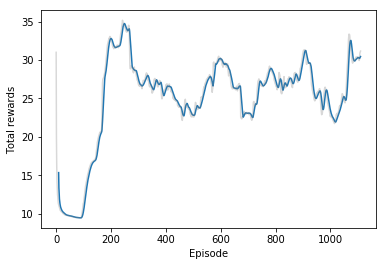

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

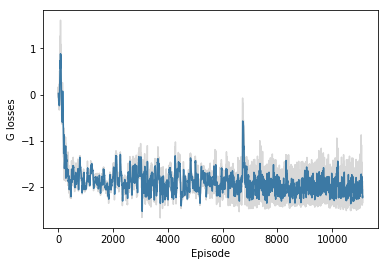

In [133]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

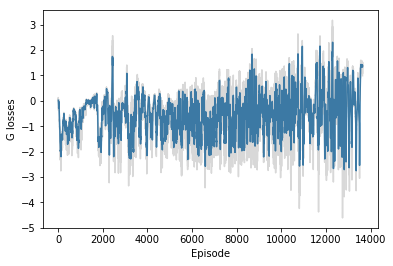

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

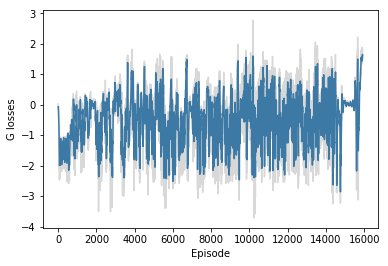
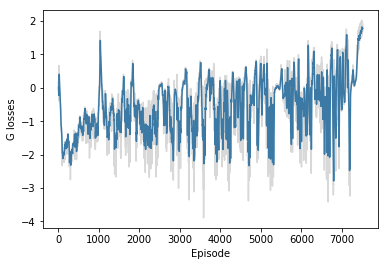

Text(0,0.5,'D losses')

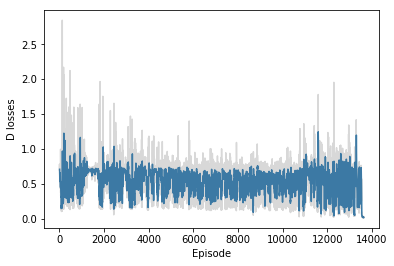

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

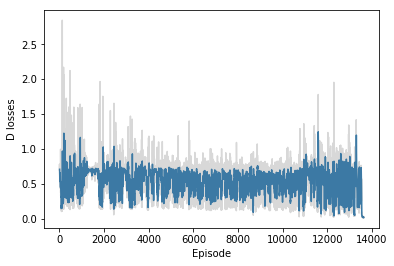

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

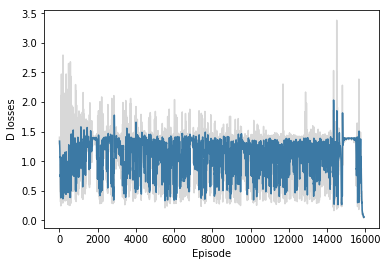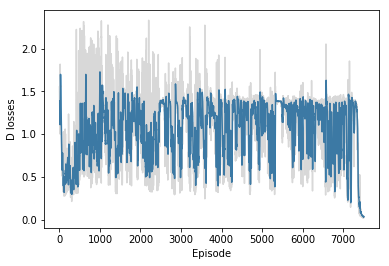

Text(0,0.5,'D losses R')

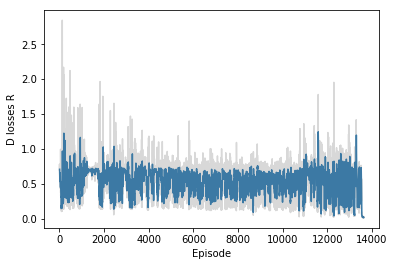

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

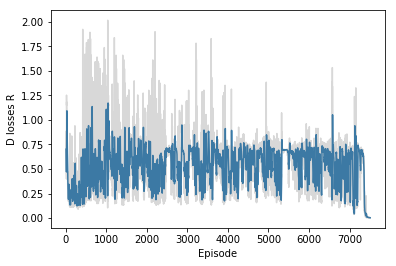

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

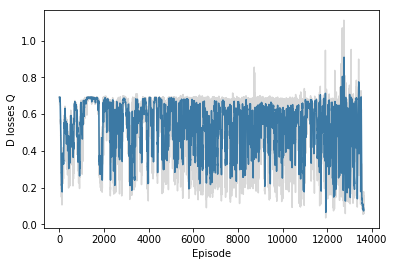

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

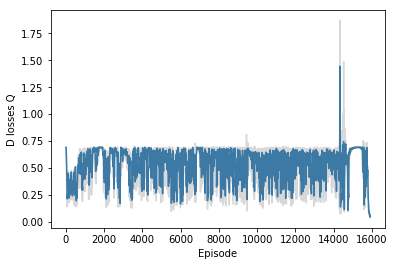

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

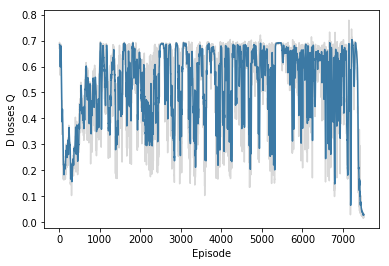

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.